In [2]:
from datetime import datetime
import datetime as dt
import time
from subgrounds.subgraph import SyntheticField, FieldPath
from subgrounds.subgrounds import Subgrounds
import pandas as pd
import duckdb as db
import seaborn as sns
import matplotlib.pyplot as plt
import IPython as ip
import  os as os


In [3]:
sg = Subgrounds()
apiKey = input('API Key, please')

In [6]:
#for when we save the files
file = input('Selet a folder to save output') ##enter your file path here - the file is in the repo "summary_stats.csv".
file = file+'/data'
if not os.path.exists(file):
    os.makedirs(file)

*******************************************************************
*******************************************************************
LET'S LOOK AT SILO BORROWS FIRST
https://app.silo.finance/silo/0xc413dd03555f3eb29d834b482d386b2999dc2eb0

In [7]:
#SILO subgraph: https://gateway.thegraph.com/api/[api-key]/subgraphs/id/6rcT2GzBXGoi3ZMus92LHajM2b9qWGj7Z3dDhPxoUogB
silo = sg.load_api('https://gateway.thegraph.com/api/'+apiKey+'/subgraphs/id/6rcT2GzBXGoi3ZMus92LHajM2b9qWGj7Z3dDhPxoUogB')

In [8]:
oldBorrowsDb = pd.DataFrame()
siloFileName = file+'/siloFinance_borrows.csv'
try:
    oldBorrowsDb = pd.read_csv (siloFileName)
except:
    oldBorrowsDb = pd.DataFrame()
oldBorrowsDb.head(100)

""


In [9]:
maxSiloBorrowTimestamp = 0
try:
    maxSiloBorrowTimestamp = (max(0,oldBorrowsDb['transaction_timestamp'].max()))-5
except:
        maxSiloBorrowTimestamp = 0
maxSiloBorrowTimestamp = int(maxSiloBorrowTimestamp)
maxSiloBorrowTimestamp

0

In [10]:
##this captures the ENTIRE list of people who borrowed XAI against gOHM
borrowTicker = 0
borrowslist = pd.DataFrame()
borrowsDb = pd.DataFrame()
borrowListLength = 1000
datediff = 0
now=0
daysAgo=0
daysLimit = 45
exit = False
while exit==False:
    skipValue = (borrowTicker)*(1000)
    borrows = silo.Query.borrows(
        orderBy='timestamp',
        orderDirection='desc',
        first=1000,
        skip = skipValue,
        where={ 'market': '0xc413dd03555f3eb29d834b482d386b2999dc2eb0'
                ,'timestamp_gte': maxSiloBorrowTimestamp
                } #gOHM market

    )

    borrowslist = sg.query_df([
        borrows.id
        ,borrows.hash
        ,borrows.blockNumber
        ,borrows.timestamp
        ,borrows.account.id
        ,borrows.market.id
        ,borrows.market.protocol.id
        ,borrows.market.rates.rate
        ,borrows.market.rates.duration
        ,borrows.market.rates.side
        ,borrows.market.rates.type
        ,borrows.market.rates.token.id
        ,borrows.asset.name
        ,borrows.asset.symbol
        ,borrows.asset.decimals
        ,borrows.asset.lastPriceUSD
        ,borrows.amount
        ,borrows.amountUSD
    ])

    #borrowslist.sort_values(by=['borrows_timestamp'])

    borrowsDb=pd.concat([borrowsDb, borrowslist])
    recordTimestamp1 = borrowsDb.iat[borrowTicker,3]
    recordTimestamp = dt.datetime.fromtimestamp( recordTimestamp1 )
    now = (int(dt.datetime.utcnow().timestamp()))
    datediff=abs(int(now) - recordTimestamp1)
    daysAgo = int(datediff/86400)
    borrowsDbLength = len(borrowsDb)
    borrowListLength = len(borrowslist)
    recordID = borrowsDb.iat[borrowTicker,0]
    borrow = borrowsDb.iat[borrowTicker,1]
    print("iterations: ", borrowTicker, "Lines skipped: ",skipValue, "records collected: ", borrowListLength, " - latest recordID: ",borrow, " ", recordID , " - borrows DB length: ", borrowsDbLength, " - latest record from: ", recordTimestamp, daysAgo,"days ago")
    #print("iterations: ", borrowTicker, "records collected: ", borrowListLength, " - userdb length: ", borrowsDbLength)
    borrowTicker = borrowTicker+1

    if daysAgo>daysLimit: exit =True
    if borrowListLength<1000: exit =True

borrowsDb.columns = borrowsDb.columns.str.replace("borrows", "transaction")
borrowsDb['event']='borrow'
borrowsDb.drop_duplicates
print("Done. Total Records collected: ", borrowsDbLength)

iterations:  0 Lines skipped:  0 records collected:  150  - latest recordID:  0xd9329978828295f4f091eaa77a6d8c388c5616bbe92c737cda5a8e695f13fdd9   0xd9329978828295f4f091eaa77a6d8c388c5616bbe92c737cda5a8e695f13fdd9-277  - borrows DB length:  150  - latest record from:  2023-02-16 15:31:47 0 days ago
Done. Total Records collected:  150


In [11]:
borrowsDb.head(100)

,transaction_id,transaction_hash,transaction_blockNumber,transaction_timestamp,transaction_account_id,transaction_market_id,transaction_market_protocol_id,transaction_market_rates_rate,transaction_market_rates_duration,transaction_market_rates_side,transaction_market_rates_type,transaction_market_rates_token_id,transaction_asset_name,transaction_asset_symbol,transaction_asset_decimals,transaction_asset_lastPriceUSD,transaction_amount,transaction_amountUSD,event
0,0xd9329978828295f4f091eaa77a6d8c388c5616bbe92c...,0xd9329978828295f4f091eaa77a6d8c388c5616bbe92c...,16644592,1676590307,0x96035b45bc0d22f0ed11283a91145fb001c48370,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.000000,None,BORROWER,VARIABLE,0x0ab87046fbb341d058f17cbc4c1133f25a20a52f,Wrapped Ether,WETH,18,1659.510994,600000000000000000,995.052978,borrow
1,0xd9329978828295f4f091eaa77a6d8c388c5616bbe92c...,0xd9329978828295f4f091eaa77a6d8c388c5616bbe92c...,16644592,1676590307,0x96035b45bc0d22f0ed11283a91145fb001c48370,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.983536,None,BORROWER,VARIABLE,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Wrapped Ether,WETH,18,1659.510994,600000000000000000,995.052978,borrow
2,0xd9329978828295f4f091eaa77a6d8c388c5616bbe92c...,0xd9329978828295f4f091eaa77a6d8c388c5616bbe92c...,16644592,1676590307,0x96035b45bc0d22f0ed11283a91145fb001c48370,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,2.211199,None,BORROWER,VARIABLE,0xd7c9f0e536dc865ae858b0c0453fe76d13c3beac,Wrapped Ether,WETH,18,1659.510994,600000000000000000,995.052978,borrow
3,0xd9329978828295f4f091eaa77a6d8c388c5616bbe92c...,0xd9329978828295f4f091eaa77a6d8c388c5616bbe92c...,16644592,1676590307,0x96035b45bc0d22f0ed11283a91145fb001c48370,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.000000,None,LENDER,VARIABLE,0x0ab87046fbb341d058f17cbc4c1133f25a20a52f,Wrapped Ether,WETH,18,1659.510994,600000000000000000,995.052978,borrow
4,0xd9329978828295f4f091eaa77a6d8c388c5616bbe92c...,0xd9329978828295f4f091eaa77a6d8c388c5616bbe92c...,16644592,1676590307,0x96035b45bc0d22f0ed11283a91145fb001c48370,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.117764,None,LENDER,VARIABLE,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Wrapped Ether,WETH,18,1659.510994,600000000000000000,995.052978,borrow
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0x4fa0cb2fdde04b90f07602351b260aa5202562c7b701...,0x4fa0cb2fdde04b90f07602351b260aa5202562c7b701...,16574830,1675747799,0x6487d336bdec94d4714a4d217b15aa5c7b9dfa99,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.977886,None,LENDER,VARIABLE,0xd7c9f0e536dc865ae858b0c0453fe76d13c3beac,XAI Stablecoin,XAI,18,0.999407,6030000000000000000000,6015.596587,borrow
96,0xb38cef69963653bc8f3e04720bd0d3f3df6e6e9ede13...,0xb38cef69963653bc8f3e04720bd0d3f3df6e6e9ede13...,16573202,1675728155,0x36125234dd6c7d0a01dcadc67e79e061d405098e,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.000000,None,BORROWER,VARIABLE,0x0ab87046fbb341d058f17cbc4c1133f25a20a52f,XAI Stablecoin,XAI,18,0.999407,25000000000000000000000,24937.155253,borrow
97,0xb38cef69963653bc8f3e04720bd0d3f3df6e6e9ede13...,0xb38cef69963653bc8f3e04720bd0d3f3df6e6e9ede13...,16573202,1675728155,0x36125234dd6c7d0a01dcadc67e79e061d405098e,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.983536,None,BORROWER,VARIABLE,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,XAI Stablecoin,XAI,18,0.999407,25000000000000000000000,24937.155253,borrow
98,0xb38cef69963653bc8f3e04720bd0d3f3df6e6e9ede13...,0xb38cef69963653bc8f3e04720bd0d3f3df6e6e9ede13...,16573202,1675728155,0x36125234dd6c7d0a01dcadc67e79e061d405098e,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,2.211199,None,BORRO

In [12]:
#I swear I will figure out synthetic fields, but until then...
borrowsDbTimed = db.query("select "
               "    * "
                    " ,to_timestamp(transaction_timestamp::int) dateTime "
               "From borrowsDb "
                      "order by transaction_amountUSD desc"
               #"where lower(liquidityPools_name) like lower('%olympus%') "
                #    "or lower(pairs_token1_symbol) like lower('%OHM%')  "
               #" limit 100 "
               ).df()
borrowsDbTimed.head(100)

,transaction_id,transaction_hash,transaction_blockNumber,transaction_timestamp,transaction_account_id,transaction_market_id,transaction_market_protocol_id,transaction_market_rates_rate,transaction_market_rates_duration,transaction_market_rates_side,transaction_market_rates_type,transaction_market_rates_token_id,transaction_asset_name,transaction_asset_symbol,transaction_asset_decimals,transaction_asset_lastPriceUSD,transaction_amount,transaction_amountUSD,event,dateTime
0,0x16f2ff52f7a9e9057848569ea37c3e59eb558af0e044...,0x16f2ff52f7a9e9057848569ea37c3e59eb558af0e044...,16589389,1675923839,0xb0399dac8f4d4100b49b2a7b3873481114229d18,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.000000,NaN,BORROWER,VARIABLE,0x0ab87046fbb341d058f17cbc4c1133f25a20a52f,XAI Stablecoin,XAI,18,0.999407,186000000000000000000000,185996.147731,borrow,2023-02-09 06:23:59
1,0x16f2ff52f7a9e9057848569ea37c3e59eb558af0e044...,0x16f2ff52f7a9e9057848569ea37c3e59eb558af0e044...,16589389,1675923839,0xb0399dac8f4d4100b49b2a7b3873481114229d18,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.983536,NaN,BORROWER,VARIABLE,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,XAI Stablecoin,XAI,18,0.999407,186000000000000000000000,185996.147731,borrow,2023-02-09 06:23:59
2,0x16f2ff52f7a9e9057848569ea37c3e59eb558af0e044...,0x16f2ff52f7a9e9057848569ea37c3e59eb558af0e044...,16589389,1675923839,0xb0399dac8f4d4100b49b2a7b3873481114229d18,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,2.211199,NaN,BORROWER,VARIABLE,0xd7c9f0e536dc865ae858b0c0453fe76d13c3beac,XAI Stablecoin,XAI,18,0.999407,186000000000000000000000,185996.147731,borrow,2023-02-09 06:23:59
3,0x16f2ff52f7a9e9057848569ea37c3e59eb558af0e044...,0x16f2ff52f7a9e9057848569ea37c3e59eb558af0e044...,16589389,1675923839,0xb0399dac8f4d4100b49b2a7b3873481114229d18,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.000000,NaN,LENDER,VARIABLE,0x0ab87046fbb341d058f17cbc4c1133f25a20a52f,XAI Stablecoin,XAI,18,0.999407,186000000000000000000000,185996.147731,borrow,2023-02-09 06:23:59
4,0x16f2ff52f7a9e9057848569ea37c3e59eb558af0e044...,0x16f2ff52f7a9e9057848569ea37c3e59eb558af0e044...,16589389,1675923839,0xb0399dac8f4d4100b49b2a7b3873481114229d18,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.117764,NaN,LENDER,VARIABLE,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,XAI Stablecoin,XAI,18,0.999407,186000000000000000000000,185996.147731,borrow,2023-02-09 06:23:59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0xfa292276fc71f90e29ca90a7b8a2be9a4094f459fb99...,0xfa292276fc71f90e29ca90a7b8a2be9a4094f459fb99...,16634870,1676472911,0x16ff8ad104fa6195260a6d4a3f311c5f120df77d,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.977886,NaN,LENDER,VARIABLE,0xd7c9f0e536dc865ae858b0c0453fe76d13c3beac,XAI Stablecoin,XAI,18,0.999407,3000000000000000000000,3023.153053,borrow,2023-02-15 14:55:11
96,0x39c11cb01e34d9f8ca55a8820482eaf8a217033cdb6f...,0x39c11cb01e34d9f8ca55a8820482eaf8a217033cdb6f...,16626801,1676375459,0x16ff8ad104fa6195260a6d4a3f311c5f120df77d,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.000000,NaN,BORROWER,VARIABLE,0x0ab87046fbb341d058f17cbc4c1133f25a20a52f,Wrapped Ether,WETH,18,1659.510994,1920000000000000000,2885.217480,borrow,2023-02-14 11:50:59
97,0x39c11cb01e34d9f8ca55a8820482eaf8a217033cdb6f...,0x39c11cb01e34d9f8ca55a8820482eaf8a217033cdb6f...,16626801,1676375459,0x16ff8ad104fa6195260a6d4a3f311c5f120df77d,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.983536,NaN,BORROWER,VARIABLE,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Wrapped Ether,WETH,18,1659.510994,1920000000000000000,2885.217480,borrow,2023-02-14 11:50:59
98,0x39c11cb01e34d9f8ca55a8820482eaf8a217033cdb6f...,0x39c11cb01e34d9f8ca55a8820

In [13]:
borrowsDbTimed = pd.concat([oldBorrowsDb,borrowsDbTimed]).drop_duplicates().reset_index(drop=True)
borrowsDbTimed.drop_duplicates()
borrowsDbTimed = db.query("select "
               "    * "
               "From borrowsDbTimed "
                         "group by 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20 "
                      "order by transaction_amountUSD desc "
               #"where lower(liquidityPools_name) like lower('%olympus%') "
                #    "or lower(pairs_token1_symbol) like lower('%OHM%')  "
               #" limit 100 "
               ).df()

borrowsDbTimed.head(100)

,transaction_id,transaction_hash,transaction_blockNumber,transaction_timestamp,transaction_account_id,transaction_market_id,transaction_market_protocol_id,transaction_market_rates_rate,transaction_market_rates_duration,transaction_market_rates_side,transaction_market_rates_type,transaction_market_rates_token_id,transaction_asset_name,transaction_asset_symbol,transaction_asset_decimals,transaction_asset_lastPriceUSD,transaction_amount,transaction_amountUSD,event,dateTime
0,0x16f2ff52f7a9e9057848569ea37c3e59eb558af0e044...,0x16f2ff52f7a9e9057848569ea37c3e59eb558af0e044...,16589389,1675923839,0xb0399dac8f4d4100b49b2a7b3873481114229d18,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.000000,NaN,BORROWER,VARIABLE,0x0ab87046fbb341d058f17cbc4c1133f25a20a52f,XAI Stablecoin,XAI,18,0.999407,186000000000000000000000,185996.147731,borrow,2023-02-09 06:23:59
1,0x16f2ff52f7a9e9057848569ea37c3e59eb558af0e044...,0x16f2ff52f7a9e9057848569ea37c3e59eb558af0e044...,16589389,1675923839,0xb0399dac8f4d4100b49b2a7b3873481114229d18,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.983536,NaN,BORROWER,VARIABLE,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,XAI Stablecoin,XAI,18,0.999407,186000000000000000000000,185996.147731,borrow,2023-02-09 06:23:59
2,0x16f2ff52f7a9e9057848569ea37c3e59eb558af0e044...,0x16f2ff52f7a9e9057848569ea37c3e59eb558af0e044...,16589389,1675923839,0xb0399dac8f4d4100b49b2a7b3873481114229d18,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,2.211199,NaN,BORROWER,VARIABLE,0xd7c9f0e536dc865ae858b0c0453fe76d13c3beac,XAI Stablecoin,XAI,18,0.999407,186000000000000000000000,185996.147731,borrow,2023-02-09 06:23:59
3,0x16f2ff52f7a9e9057848569ea37c3e59eb558af0e044...,0x16f2ff52f7a9e9057848569ea37c3e59eb558af0e044...,16589389,1675923839,0xb0399dac8f4d4100b49b2a7b3873481114229d18,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.000000,NaN,LENDER,VARIABLE,0x0ab87046fbb341d058f17cbc4c1133f25a20a52f,XAI Stablecoin,XAI,18,0.999407,186000000000000000000000,185996.147731,borrow,2023-02-09 06:23:59
4,0x16f2ff52f7a9e9057848569ea37c3e59eb558af0e044...,0x16f2ff52f7a9e9057848569ea37c3e59eb558af0e044...,16589389,1675923839,0xb0399dac8f4d4100b49b2a7b3873481114229d18,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.117764,NaN,LENDER,VARIABLE,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,XAI Stablecoin,XAI,18,0.999407,186000000000000000000000,185996.147731,borrow,2023-02-09 06:23:59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0xfa292276fc71f90e29ca90a7b8a2be9a4094f459fb99...,0xfa292276fc71f90e29ca90a7b8a2be9a4094f459fb99...,16634870,1676472911,0x16ff8ad104fa6195260a6d4a3f311c5f120df77d,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.977886,NaN,LENDER,VARIABLE,0xd7c9f0e536dc865ae858b0c0453fe76d13c3beac,XAI Stablecoin,XAI,18,0.999407,3000000000000000000000,3023.153053,borrow,2023-02-15 14:55:11
96,0x39c11cb01e34d9f8ca55a8820482eaf8a217033cdb6f...,0x39c11cb01e34d9f8ca55a8820482eaf8a217033cdb6f...,16626801,1676375459,0x16ff8ad104fa6195260a6d4a3f311c5f120df77d,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.000000,NaN,BORROWER,VARIABLE,0x0ab87046fbb341d058f17cbc4c1133f25a20a52f,Wrapped Ether,WETH,18,1659.510994,1920000000000000000,2885.217480,borrow,2023-02-14 11:50:59
97,0x39c11cb01e34d9f8ca55a8820482eaf8a217033cdb6f...,0x39c11cb01e34d9f8ca55a8820482eaf8a217033cdb6f...,16626801,1676375459,0x16ff8ad104fa6195260a6d4a3f311c5f120df77d,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.983536,NaN,BORROWER,VARIABLE,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Wrapped Ether,WETH,18,1659.510994,1920000000000000000,2885.217480,borrow,2023-02-14 11:50:59
98,0x39c11cb01e34d9f8ca55a8820482eaf8a217033cdb6f...,0x39c11cb01e34d9f8ca55a8820

In [18]:
siloBorrowEventsDbTimedClean = db.query("select "
                            " transaction_id"
                            " ,event "
                            ", transaction_hash "
                            ", transaction_blockNumber "
                            ", transaction_timestamp "
                            ", transaction_account_id "
                            ", transaction_market_id "
                            ", transaction_asset_name "
                            ", transaction_asset_symbol "
                            ", transaction_amount "
                            ", (transaction_amount::hugeint*1e-17) transactionReadableAmount "
                            ", transaction_amountUSD "
                            ", dateTime "
                            ", date_trunc('day', dateTime) calDate "
               "From borrowsDbTimed "
                         "group by"
                            " transaction_id"
                            " ,event "
                            ", transaction_hash "
                            ", transaction_blockNumber "
                            ", transaction_timestamp "
                            ", transaction_account_id "
                            ", transaction_market_id "
                            ", transaction_asset_name "
                            ", transaction_asset_symbol "
                            ", transaction_amount "
                            ", transaction_amountUSD "
                            ", dateTime "
                      "order by transaction_amountUSD desc "
               #"where lower(liquidityPools_name) like lower('%olympus%') "
                #    "or lower(pairs_token1_symbol) like lower('%OHM%')  "
               #" limit 100 "
               ).df()
siloBorrowEventsDbTimedClean.head(100)

,transaction_id,event,transaction_hash,transaction_blockNumber,transaction_timestamp,transaction_account_id,transaction_market_id,transaction_asset_name,transaction_asset_symbol,transaction_amount,transactionReadableAmount,transaction_amountUSD,dateTime,calDate
0,0x16f2ff52f7a9e9057848569ea37c3e59eb558af0e044...,borrow,0x16f2ff52f7a9e9057848569ea37c3e59eb558af0e044...,16589389,1675923839,0xb0399dac8f4d4100b49b2a7b3873481114229d18,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,XAI Stablecoin,XAI,186000000000000000000000,1.860000e+06,185996.147731,2023-02-09 06:23:59,2023-02-09
1,0x3b0f26e10c63a71c916e8a68bd1889d9bab38aeb62d7...,borrow,0x3b0f26e10c63a71c916e8a68bd1889d9bab38aeb62d7...,16641746,1676556011,0xee95e4cf086fc80df7ae0f39dfc9ea53a3eaadcb,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,XAI Stablecoin,XAI,100000000000000000000000,1.000000e+06,100012.487283,2023-02-16 14:00:11,2023-02-16
2,0x3dba2dd3c913b399164efd71db73121c9c94c0096139...,borrow,0x3dba2dd3c913b399164efd71db73121c9c94c0096139...,16622907,1676328371,0x46535cbc3fa574c32ea392d4f89c518290597072,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,Governance OHM,gOHM,26400000000000000000,2.640000e+02,71910.521424,2023-02-13 22:46:11,2023-02-13
3,0x072c04ee8776ea91e8c1003bad2d401e3ac90d0ab2fc...,borrow,0x072c04ee8776ea91e8c1003bad2d401e3ac90d0ab2fc...,16579820,1675808183,0x0493bcca897a2248ae3cd4c66aea90dbfc7e13c6,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,XAI Stablecoin,XAI,30000000000000000000000,3.000000e+05,29884.417447,2023-02-07 22:16:23,2023-02-07
4,0xb38cef69963653bc8f3e04720bd0d3f3df6e6e9ede13...,borrow,0xb38cef69963653bc8f3e04720bd0d3f3df6e6e9ede13...,16573202,1675728155,0x36125234dd6c7d0a01dcadc67e79e061d405098e,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,XAI Stablecoin,XAI,25000000000000000000000,2.500000e+05,24937.155253,2023-02-07 00:02:35,2023-02-07
5,0x38ce8e39e188c85ba03a340cdde95c2e1d56b54161e6...,borrow,0x38ce8e39e188c85ba03a340cdde95c2e1d56b54161e6...,16579819,1675808171,0x96035b45bc0d22f0ed11283a91145fb001c48370,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,XAI Stablecoin,XAI,20000000000000000000000,2.000000e+05,19922.944964,2023-02-07 22:16:11,2023-02-07
6,0x2485acd5a3853dc50921a27ea5bf8227871425cca3e4...,borrow,0x2485acd5a3853dc50921a27ea5bf8227871425cca3e4...,16171818,1670886647,0x1ba67f30e25fc43863b50047d7fd4bd63b9c59ec,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,XAI Stablecoin,XAI,11900000000000000000000,1.190000e+05,11928.568949,2022-12-12 23:10:47,2022-12-12
7,0xe034b0dedaea9ad1f849d5420228106937d816b89b3a...,borrow,0xe034b0dedaea9ad1f849d5420228106937d816b89b3a...,16505284,1674908519,0x42daeb9ca091e3933c8ee93c029701b926b1f336,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,XAI Stablecoin,XAI,10000000000000000000000,1.000000e+05,10040.961438,2023-01-28 12:21:59,2023-01-28
8,0xbfc6df3a770233f4e0fbd6fe0cf8f6fa02f1432c570f...,borrow,0xbfc6df3a770233f4e0fbd6fe0cf8f6fa02f1432c570f...,16173505,1670906999,0x339fd7c17ce670e7821f2f2ee94ddd49771483da,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,XAI Stablecoin,XAI,8000000000000000000000,8.000000e+04,8040.631376,2022-12-13 04:49:59,2022-12-13
9,0x045f19530c6f8c0b6eca525f3921e207938e841b3670...,borrow,0x045f19530c6f8c0b6eca525f3921e207938e841b3670...,16580114,1675811711,0xb86cd2efc1f461beee8deec2c3f053ccb2781ef9,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,XAI Stablecoin,XAI,7000000000000000000000,7.000000e+04,6976.053341,2023-02-07 23:15:11,2023-02-07


In [19]:
path =file+'/siloFinance_borrows.csv'
siloBorrowEventsDbTimedClean.to_csv(path, index = False)

path =file+'/siloFinance_borrows_piped.csv'
siloBorrowEventsDbTimedClean.to_csv(path, index = False, sep='|')
print(path, 'file saved,', len(borrowsDbTimed),' records')

D:\Dropbox\Documents\Edgecaser LLC\Projects\Olympus\Econohmetrics\gohmAsStablecoinCollateral/data/siloFinance_borrows_piped.csv file saved, 150  records


In [20]:
totalBorrowed = sum(siloBorrowEventsDbTimedClean['transactionReadableAmount'])
print('There has been a total of',round(totalBorrowed,2),  'OHM borrowed cumulatively to date')

There has been a total of 4286670.04 OHM borrowed cumulatively to date


[Text(0.5, 1.0, 'OHM borrowed per day'), Text(0.5, 0, 'Date'), Text(0, 0.5, 'OHM')]


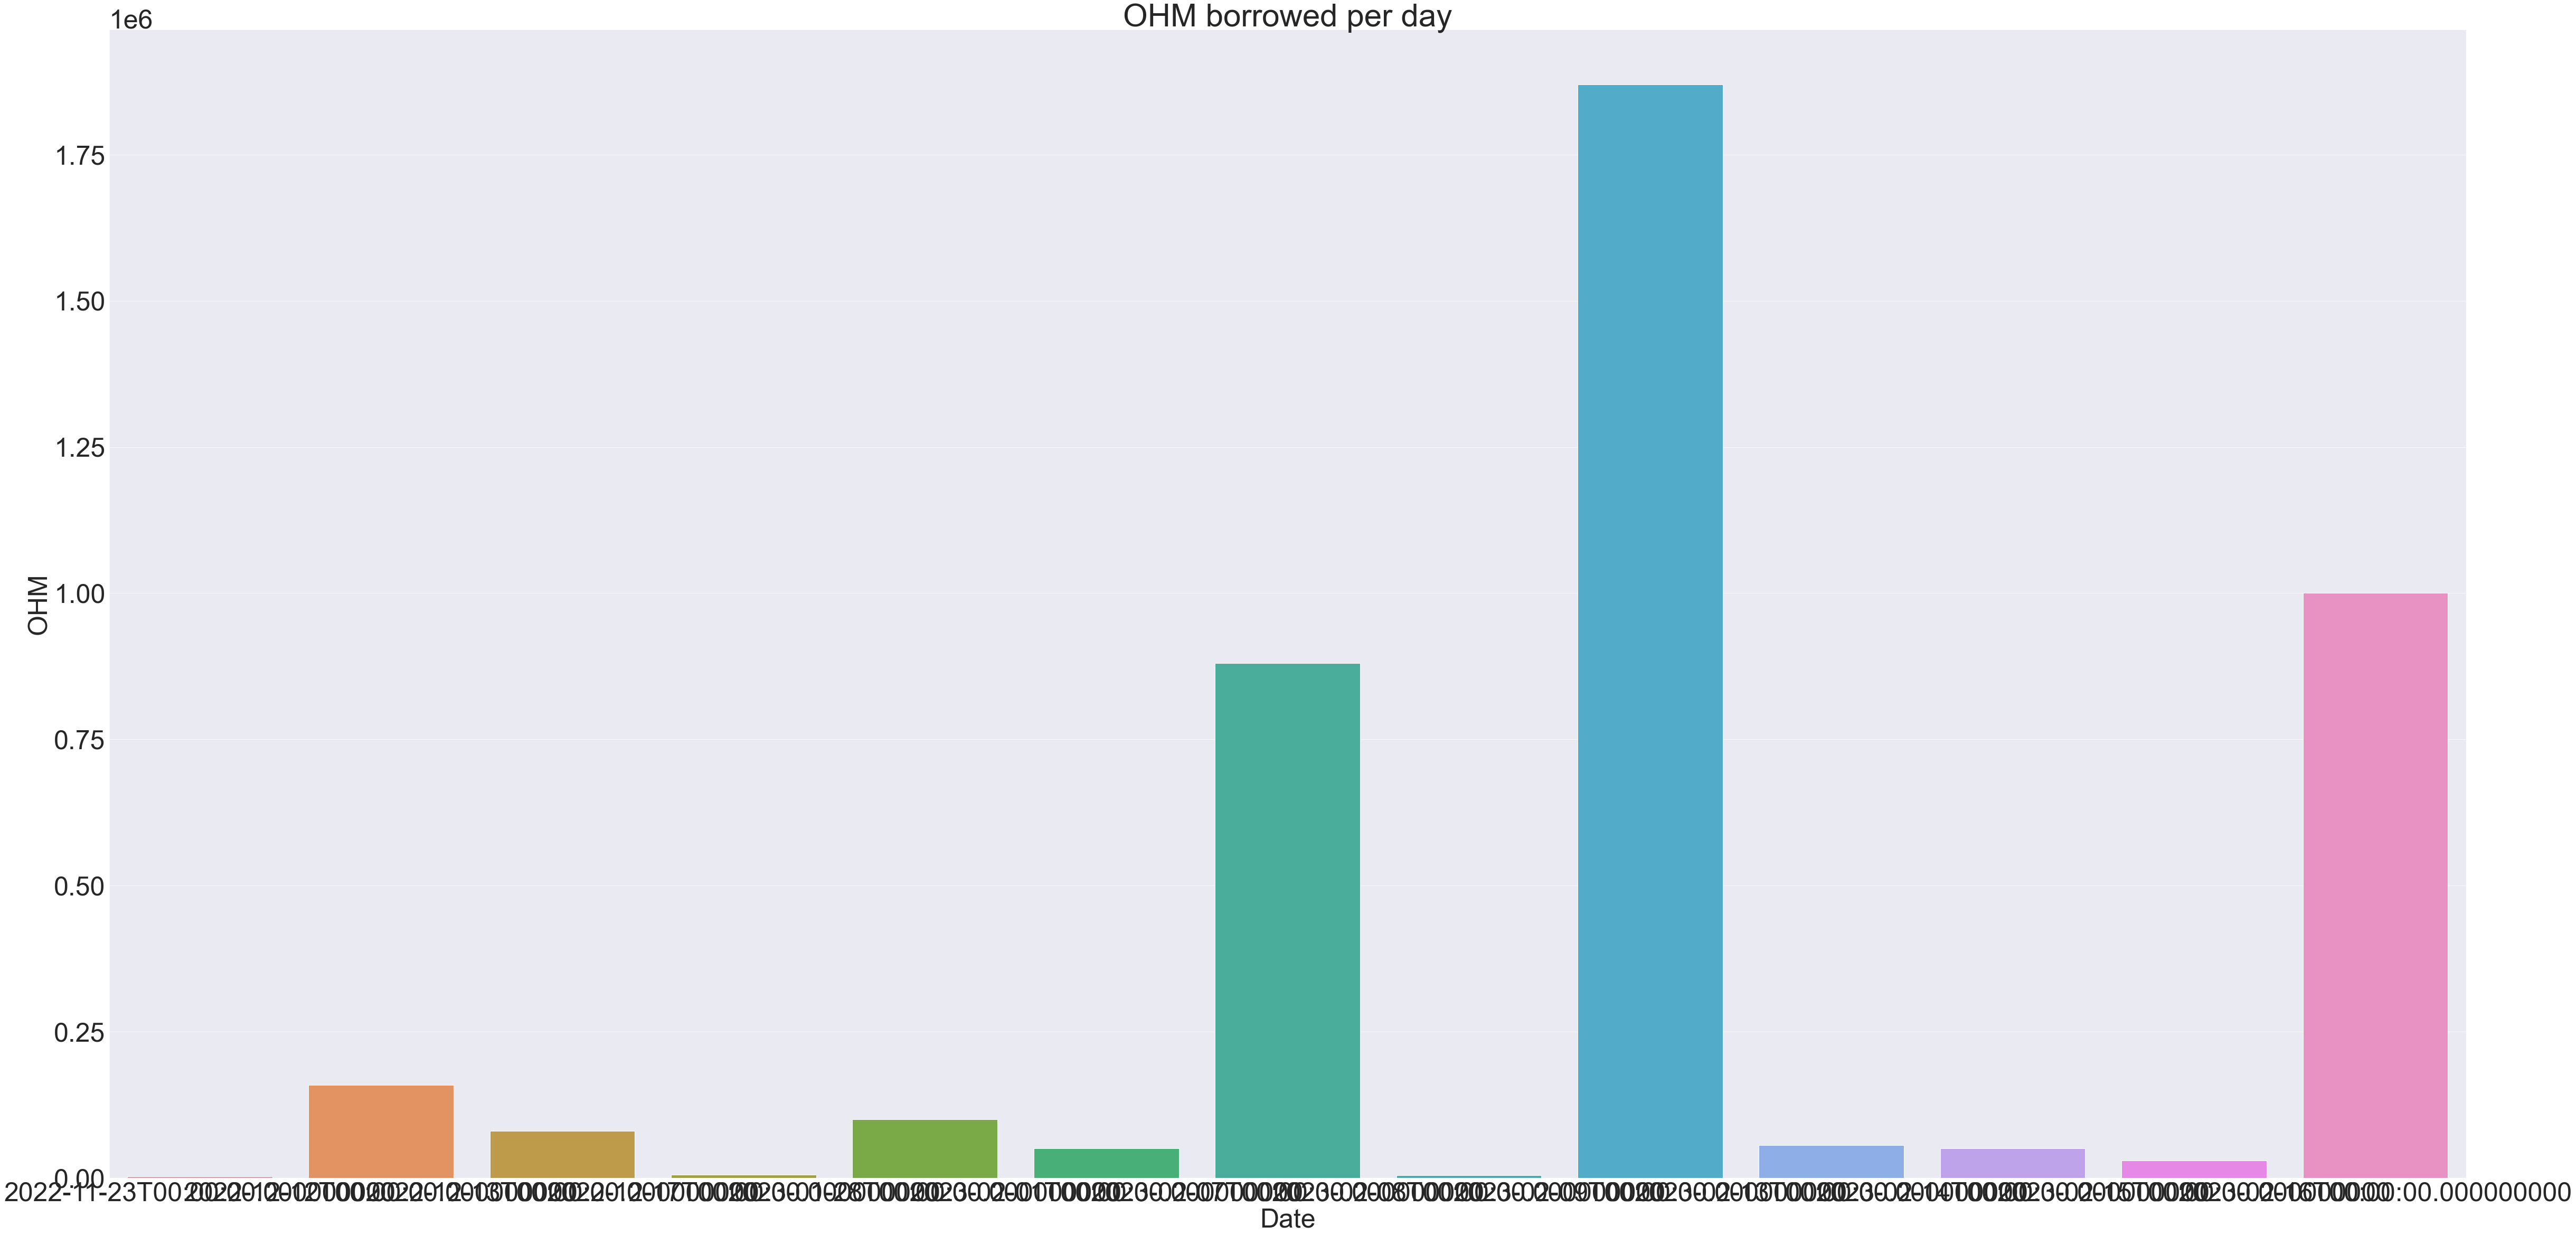

In [23]:
plt.rc("figure", figsize=(80, 40))
#sns.set_style("whitegrid")
plt.rc("font", size=50)


value_locked = siloBorrowEventsDbTimedClean.groupby("calDate")["transactionReadableAmount"].agg("sum").reset_index()
plot_title = 'OHM borrowed per day'
chart=sns.barplot(data=value_locked,y="transactionReadableAmount",x="calDate").set(title = plot_title, xlabel = 'Date', ylabel = 'OHM', )
print(chart)

********************************************************************************************
********************************************************************************************
Silo Repays

In [202]:
oldRepaysDb = pd.DataFrame()
siloFileName = file+'/siloFinance_repays.csv'
try:
    oldRepaysDb = pd.read_csv (siloFileName)
except:
    oldRepaysDb = pd.DataFrame()
oldRepaysDb.head(100)

,transaction_id,transaction_hash,transaction_blockNumber,transaction_timestamp,transaction_account_id,transaction_market_id,transaction_market_protocol_id,transaction_market_rates_rate,transaction_market_rates_duration,transaction_market_rates_side,...,transaction_market_rates_token_id,transaction_asset_name,transaction_asset_symbol,transaction_asset_decimals,transaction_asset_lastPriceUSD,transaction_amount,transaction_amountUSD,event,dateTime,dateTime_2
0,0xfb97f8e2544f2063f69249a0ba2138b8272c34596661...,0xfb97f8e2544f2063f69249a0ba2138b8272c34596661...,16628154,1676391755,0xb0399dac8f4d4100b49b2a7b3873481114229d18,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.000000,NaN,BORROWER,...,0x0ab87046fbb341d058f17cbc4c1133f25a20a52f,XAI Stablecoin,XAI,18,0.999467,100000000000000000000000,100169.938162,repay,2023-02-14 16:22:35,2023-02-14 16:22:35
1,0xfb97f8e2544f2063f69249a0ba2138b8272c34596661...,0xfb97f8e2544f2063f69249a0ba2138b8272c34596661...,16628154,1676391755,0xb0399dac8f4d4100b49b2a7b3873481114229d18,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,2.278084,NaN,BORROWER,...,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,XAI Stablecoin,XAI,18,0.999467,100000000000000000000000,100169.938162,repay,2023-02-14 16:22:35,2023-02-14 16:22:35
2,0xfb97f8e2544f2063f69249a0ba2138b8272c34596661...,0xfb97f8e2544f2063f69249a0ba2138b8272c34596661...,16628154,1676391755,0xb0399dac8f4d4100b49b2a7b3873481114229d18,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,2.347562,NaN,BORROWER,...,0xd7c9f0e536dc865ae858b0c0453fe76d13c3beac,XAI Stablecoin,XAI,18,0.999467,100000000000000000000000,100169.938162,repay,2023-02-14 16:22:35,2023-02-14 16:22:35
3,0xfb97f8e2544f2063f69249a0ba2138b8272c34596661...,0xfb97f8e2544f2063f69249a0ba2138b8272c34596661...,16628154,1676391755,0xb0399dac8f4d4100b49b2a7b3873481114229d18,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.000000,NaN,LENDER,...,0x0ab87046fbb341d058f17cbc4c1133f25a20a52f,XAI Stablecoin,XAI,18,0.999467,100000000000000000000000,100169.938162,repay,2023-02-14 16:22:35,2023-02-14 16:22:35
4,0xfb97f8e2544f2063f69249a0ba2138b8272c34596661...,0xfb97f8e2544f2063f69249a0ba2138b8272c34596661...,16628154,1676391755,0xb0399dac8f4d4100b49b2a7b3873481114229d18,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.631786,NaN,LENDER,...,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,XAI Stablecoin,XAI,18,0.999467,100000000000000000000000,100169.938162,repay,2023-02-14 16:22:35,2023-02-14 16:22:35
5,0xfb97f8e2544f2063f69249a0ba2138b8272c34596661...,0xfb97f8e2544f2063f69249a0ba2138b8272c34596661...,16628154,1676391755,0xb0399dac8f4d4100b49b2a7b3873481114229d18,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,1.102211,NaN,LENDER,...,0xd7c9f0e536dc865ae858b0c0453fe76d13c3beac,XAI Stablecoin,XAI,18,0.999467,100000000000000000000000,100169.938162,repay,2023-02-14 16:22:35,2023-02-14 16:22:35
6,0xcbfc584edeb424b312011c7884bce8c77facd5b4bad8...,0xcbfc584edeb424b312011c7884bce8c77facd5b4bad8...,16626928,1676376983,0x46535cbc3fa574c32ea392d4f89c518290597072,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.000000,NaN,BORROWER,...,0x0ab87046fbb341d058f17cbc4c1133f25a20a52f,Governance OHM,gOHM,18,2805.313242,26400333491938938022,71784.459721,repay,2023-02-14 12:16:23,2023-02-14 12:16:23
7,0xcbfc584edeb424b312011c7884bce8c77facd5b4bad8...,0xcbfc584edeb424b312011c7884bce8c77facd5b4bad8...,16626928,1676376983,0x46535cbc3fa574c32ea392d4f89c518290597072,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,2.278084,NaN,BORROWER,...,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Governance OHM,gOHM,18,2805.313242,26400333491938938022,71784.459721,repay,2023-02-14 12:16:23,2023-02-14 12:16:23
8,0xcbfc584edeb424b312011c7884bce8c77facd5b4bad8...,0xcbfc58

In [203]:
maxRepaySiloTimestamp = 0
try:
    maxRepaySiloTimestamp = (max(1,oldRepaysDb['transaction_timestamp'].max()))-5
except:
        maxRepaySiloTimestamp = 0
maxRepaySiloTimestamp = int(maxRepaySiloTimestamp)
maxRepaySiloTimestamp

1676391750

In [206]:
##this tracks the ENTIRE list of events for repaying the XAI repayed against gOHM
repayTicker = 0
repayslist = pd.DataFrame()
repaysDb = pd.DataFrame()
repayListLength = 1000
datediff = 0
now=0
daysAgo=0
daysLimit = 45
exit = False
while exit==False:
    skipValue = (repayTicker)*(1000)
    repays = silo.Query.repays(
        orderBy='timestamp',
        orderDirection='desc',
        first=1000,
        skip = skipValue,
        where={ 'market': '0xc413dd03555f3eb29d834b482d386b2999dc2eb0'  #gOHM market
                ,'timestamp_gte': maxRepaySiloTimestamp
                } #gOHM market

    )

    repayslist = sg.query_df([
        repays.id
        ,repays.hash
        ,repays.blockNumber
        ,repays.timestamp
        ,repays.account.id
        ,repays.market.id
        ,repays.market.protocol.id
        ,repays.market.rates.rate
        ,repays.market.rates.duration
        ,repays.market.rates.side
        ,repays.market.rates.type
        ,repays.market.rates.token.id
        ,repays.asset.name
        ,repays.asset.symbol
        ,repays.asset.decimals
        ,repays.asset.lastPriceUSD
        ,repays.amount
        ,repays.amountUSD
    ])

    #repayslist.sort_values(by=['repays_timestamp'])

    repaysDb=pd.concat([repaysDb, repayslist])
    recordTimestamp1 = repaysDb.iat[repayTicker,3]
    recordTimestamp = dt.datetime.fromtimestamp( recordTimestamp1 )
    now = (int(dt.datetime.utcnow().timestamp()))
    datediff=abs(int(now) - recordTimestamp1)
    daysAgo = int(datediff/86400)
    repaysDbLength = len(repaysDb)
    repayListLength = len(repayslist)
    recordID = repaysDb.iat[repayTicker,0]
    repay = repaysDb.iat[repayTicker,1]
    print("iterations: ", repayTicker, "Lines skipped: ",skipValue, "records collected: ", repayListLength, " - latest recordID: ",repay, " ", recordID , " - repays DB length: ", repaysDbLength, " - latest record from: ", recordTimestamp, daysAgo,"days ago")
    #print("iterations: ", repayTicker, "records collected: ", repayListLength, " - userdb length: ", repaysDbLength)
    repayTicker = repayTicker+1

    if daysAgo>daysLimit: exit =True
    if repayListLength<1000: exit =True

repaysDb.columns = repaysDb.columns.str.replace("repays", "transaction")
repaysDb['event']='repay'
repaysDb.drop_duplicates()
print("Done. Total Records collected: ", repaysDbLength)

iterations:  0 Lines skipped:  0 records collected:  6  - latest recordID:  0xfb97f8e2544f2063f69249a0ba2138b8272c3459666153b9ce269399f5622f7e   0xfb97f8e2544f2063f69249a0ba2138b8272c3459666153b9ce269399f5622f7e-185  - repays DB length:  6  - latest record from:  2023-02-14 08:22:35 0 days ago
Done. Total Records collected:  6


In [207]:
#I swear I will figure out synthetic fields, but until then...
repaysDbDbTimed = db.query("select "
               "    * "
                    " ,to_timestamp(transaction_timestamp::int) dateTime "
               "From repaysDb "
                      "order by transaction_amountUSD desc"
               #"where lower(liquidityPools_name) like lower('%olympus%') "
                #    "or lower(pairs_token1_symbol) like lower('%OHM%')  "
               #" limit 100 "
               ).df()
repaysDbDbTimed.head(100)

,transaction_id,transaction_hash,transaction_blockNumber,transaction_timestamp,transaction_account_id,transaction_market_id,transaction_market_protocol_id,transaction_market_rates_rate,transaction_market_rates_duration,transaction_market_rates_side,transaction_market_rates_type,transaction_market_rates_token_id,transaction_asset_name,transaction_asset_symbol,transaction_asset_decimals,transaction_asset_lastPriceUSD,transaction_amount,transaction_amountUSD,event,dateTime
0,0xfb97f8e2544f2063f69249a0ba2138b8272c34596661...,0xfb97f8e2544f2063f69249a0ba2138b8272c34596661...,16628154,1676391755,0xb0399dac8f4d4100b49b2a7b3873481114229d18,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.000000,NaN,BORROWER,VARIABLE,0x0ab87046fbb341d058f17cbc4c1133f25a20a52f,XAI Stablecoin,XAI,18,0.993048,100000000000000000000000,100169.938162,repay,2023-02-14 16:22:35
1,0xfb97f8e2544f2063f69249a0ba2138b8272c34596661...,0xfb97f8e2544f2063f69249a0ba2138b8272c34596661...,16628154,1676391755,0xb0399dac8f4d4100b49b2a7b3873481114229d18,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,2.278084,NaN,BORROWER,VARIABLE,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,XAI Stablecoin,XAI,18,0.993048,100000000000000000000000,100169.938162,repay,2023-02-14 16:22:35
2,0xfb97f8e2544f2063f69249a0ba2138b8272c34596661...,0xfb97f8e2544f2063f69249a0ba2138b8272c34596661...,16628154,1676391755,0xb0399dac8f4d4100b49b2a7b3873481114229d18,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,2.347562,NaN,BORROWER,VARIABLE,0xd7c9f0e536dc865ae858b0c0453fe76d13c3beac,XAI Stablecoin,XAI,18,0.993048,100000000000000000000000,100169.938162,repay,2023-02-14 16:22:35
3,0xfb97f8e2544f2063f69249a0ba2138b8272c34596661...,0xfb97f8e2544f2063f69249a0ba2138b8272c34596661...,16628154,1676391755,0xb0399dac8f4d4100b49b2a7b3873481114229d18,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.000000,NaN,LENDER,VARIABLE,0x0ab87046fbb341d058f17cbc4c1133f25a20a52f,XAI Stablecoin,XAI,18,0.993048,100000000000000000000000,100169.938162,repay,2023-02-14 16:22:35
4,0xfb97f8e2544f2063f69249a0ba2138b8272c34596661...,0xfb97f8e2544f2063f69249a0ba2138b8272c34596661...,16628154,1676391755,0xb0399dac8f4d4100b49b2a7b3873481114229d18,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.631787,NaN,LENDER,VARIABLE,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,XAI Stablecoin,XAI,18,0.993048,100000000000000000000000,100169.938162,repay,2023-02-14 16:22:35
5,0xfb97f8e2544f2063f69249a0ba2138b8272c34596661...,0xfb97f8e2544f2063f69249a0ba2138b8272c34596661...,16628154,1676391755,0xb0399dac8f4d4100b49b2a7b3873481114229d18,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,1.102212,NaN,LENDER,VARIABLE,0xd7c9f0e536dc865ae858b0c0453fe76d13c3beac,XAI Stablecoin,XAI,18,0.993048,100000000000000000000000,100169.938162,repay,2023-02-14 16:22:35


Why the heck do I see several interest rates for the same txn?

In [208]:
repaysDbTimed = pd.concat([oldRepaysDb,repaysDbDbTimed]).drop_duplicates().reset_index(drop=True)
repaysDbTimed.sort_values(['transaction_id','transaction_market_rates_rate'])
repaysDbTimed.drop_duplicates(keep='first' )

repaysDbTimed = db.query("select "
               "    * "
               "From repaysDbDbTimed "
                         "group by 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20 "
                      "order by transaction_amountUSD desc "
               #"where lower(liquidityPools_name) like lower('%olympus%') "
                #    "or lower(pairs_token1_symbol) like lower('%OHM%')  "
               #" limit 100 "
               ).df()


repaysDbTimed.head(100)

,transaction_id,transaction_hash,transaction_blockNumber,transaction_timestamp,transaction_account_id,transaction_market_id,transaction_market_protocol_id,transaction_market_rates_rate,transaction_market_rates_duration,transaction_market_rates_side,...,transaction_market_rates_token_id,transaction_asset_name,transaction_asset_symbol,transaction_asset_decimals,transaction_asset_lastPriceUSD,transaction_amount,transaction_amountUSD,event,dateTime,dateTime_2
0,0xfb97f8e2544f2063f69249a0ba2138b8272c34596661...,0xfb97f8e2544f2063f69249a0ba2138b8272c34596661...,16628154,1676391755,0xb0399dac8f4d4100b49b2a7b3873481114229d18,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.000000,NaN,BORROWER,...,0x0ab87046fbb341d058f17cbc4c1133f25a20a52f,XAI Stablecoin,XAI,18,0.993048,100000000000000000000000,100169.938162,repay,2023-02-14 16:22:35,2023-02-14 16:22:35
1,0xfb97f8e2544f2063f69249a0ba2138b8272c34596661...,0xfb97f8e2544f2063f69249a0ba2138b8272c34596661...,16628154,1676391755,0xb0399dac8f4d4100b49b2a7b3873481114229d18,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,2.278084,NaN,BORROWER,...,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,XAI Stablecoin,XAI,18,0.993048,100000000000000000000000,100169.938162,repay,2023-02-14 16:22:35,2023-02-14 16:22:35
2,0xfb97f8e2544f2063f69249a0ba2138b8272c34596661...,0xfb97f8e2544f2063f69249a0ba2138b8272c34596661...,16628154,1676391755,0xb0399dac8f4d4100b49b2a7b3873481114229d18,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,2.347562,NaN,BORROWER,...,0xd7c9f0e536dc865ae858b0c0453fe76d13c3beac,XAI Stablecoin,XAI,18,0.993048,100000000000000000000000,100169.938162,repay,2023-02-14 16:22:35,2023-02-14 16:22:35
3,0xfb97f8e2544f2063f69249a0ba2138b8272c34596661...,0xfb97f8e2544f2063f69249a0ba2138b8272c34596661...,16628154,1676391755,0xb0399dac8f4d4100b49b2a7b3873481114229d18,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.000000,NaN,LENDER,...,0x0ab87046fbb341d058f17cbc4c1133f25a20a52f,XAI Stablecoin,XAI,18,0.993048,100000000000000000000000,100169.938162,repay,2023-02-14 16:22:35,2023-02-14 16:22:35
4,0xfb97f8e2544f2063f69249a0ba2138b8272c34596661...,0xfb97f8e2544f2063f69249a0ba2138b8272c34596661...,16628154,1676391755,0xb0399dac8f4d4100b49b2a7b3873481114229d18,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.631787,NaN,LENDER,...,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,XAI Stablecoin,XAI,18,0.993048,100000000000000000000000,100169.938162,repay,2023-02-14 16:22:35,2023-02-14 16:22:35
5,0xfb97f8e2544f2063f69249a0ba2138b8272c34596661...,0xfb97f8e2544f2063f69249a0ba2138b8272c34596661...,16628154,1676391755,0xb0399dac8f4d4100b49b2a7b3873481114229d18,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,1.102212,NaN,LENDER,...,0xd7c9f0e536dc865ae858b0c0453fe76d13c3beac,XAI Stablecoin,XAI,18,0.993048,100000000000000000000000,100169.938162,repay,2023-02-14 16:22:35,2023-02-14 16:22:35


In [210]:
path =file+'/siloFinance_repays.csv'
repaysDbTimed.to_csv(path, index = False)

path =file+'/siloFinance_repays_piped.csv'
repaysDbTimed.to_csv(path, index = False, sep='|')
print(path, 'file saved,', len(repaysDbTimed),' records')

D:\Dropbox\Documents\Edgecaser LLC\Projects\Olympus\Econohmetrics\Lending\results/siloFinance_repays_piped.csv file saved, 6  records


********************************************************************************************
********************************************************************************************
SILO DEPOSITS

In [215]:
oldDepositsDb = pd.DataFrame()
siloFileName = file+'/siloFinance_deposits.csv'
try:
    oldDepositsDb = pd.read_csv (siloFileName)
except:
    oldDepositsDb = pd.DataFrame()
oldDepositsDb.head(10)

,transaction_id,transaction_hash,transaction_blockNumber,transaction_timestamp,transaction_account_id,transaction_market_id,transaction_market_protocol_id,transaction_market_rates_rate,transaction_market_rates_duration,transaction_market_rates_side,transaction_market_rates_type,transaction_market_rates_token_id,transaction_asset_name,transaction_asset_symbol,transaction_asset_decimals,transaction_asset_lastPriceUSD,transaction_amount,transaction_amountUSD,event,dateTime
0,0x852e34f51e79d0b0695baaeffaccdd8c8406ba55e2c4...,0x852e34f51e79d0b0695baaeffaccdd8c8406ba55e2c4...,16570091,1675690667,0xb98bc3e3b9ea8d86f6ee321737fa23710737f1af,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.000000,NaN,BORROWER,VARIABLE,0x0ab87046fbb341d058f17cbc4c1133f25a20a52f,XAI Stablecoin,XAI,18,0.998196,400000000000000000000000,398901.450853,deposit,2023-02-06 13:37:47
1,0x852e34f51e79d0b0695baaeffaccdd8c8406ba55e2c4...,0x852e34f51e79d0b0695baaeffaccdd8c8406ba55e2c4...,16570091,1675690667,0xb98bc3e3b9ea8d86f6ee321737fa23710737f1af,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,2.278084,NaN,BORROWER,VARIABLE,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,XAI Stablecoin,XAI,18,0.998196,400000000000000000000000,398901.450853,deposit,2023-02-06 13:37:47
2,0x852e34f51e79d0b0695baaeffaccdd8c8406ba55e2c4...,0x852e34f51e79d0b0695baaeffaccdd8c8406ba55e2c4...,16570091,1675690667,0xb98bc3e3b9ea8d86f6ee321737fa23710737f1af,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,2.347562,NaN,BORROWER,VARIABLE,0xd7c9f0e536dc865ae858b0c0453fe76d13c3beac,XAI Stablecoin,XAI,18,0.998196,400000000000000000000000,398901.450853,deposit,2023-02-06 13:37:47
3,0x852e34f51e79d0b0695baaeffaccdd8c8406ba55e2c4...,0x852e34f51e79d0b0695baaeffaccdd8c8406ba55e2c4...,16570091,1675690667,0xb98bc3e3b9ea8d86f6ee321737fa23710737f1af,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.000000,NaN,LENDER,VARIABLE,0x0ab87046fbb341d058f17cbc4c1133f25a20a52f,XAI Stablecoin,XAI,18,0.998196,400000000000000000000000,398901.450853,deposit,2023-02-06 13:37:47
4,0x852e34f51e79d0b0695baaeffaccdd8c8406ba55e2c4...,0x852e34f51e79d0b0695baaeffaccdd8c8406ba55e2c4...,16570091,1675690667,0xb98bc3e3b9ea8d86f6ee321737fa23710737f1af,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.631787,NaN,LENDER,VARIABLE,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,XAI Stablecoin,XAI,18,0.998196,400000000000000000000000,398901.450853,deposit,2023-02-06 13:37:47
5,0x852e34f51e79d0b0695baaeffaccdd8c8406ba55e2c4...,0x852e34f51e79d0b0695baaeffaccdd8c8406ba55e2c4...,16570091,1675690667,0xb98bc3e3b9ea8d86f6ee321737fa23710737f1af,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,1.102212,NaN,LENDER,VARIABLE,0xd7c9f0e536dc865ae858b0c0453fe76d13c3beac,XAI Stablecoin,XAI,18,0.998196,400000000000000000000000,398901.450853,deposit,2023-02-06 13:37:47
6,0x204aee0831212791916d6ed3a2c24b5ac2a474743713...,0x204aee0831212791916d6ed3a2c24b5ac2a474743713...,16589368,1675923587,0xb0399dac8f4d4100b49b2a7b3873481114229d18,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.000000,NaN,BORROWER,VARIABLE,0x0ab87046fbb341d058f17cbc4c1133f25a20a52f,Governance OHM,gOHM,18,2805.495035,119000000000000000000,315110.337935,deposit,2023-02-09 06:19:47
7,0x204aee0831212791916d6ed3a2c24b5ac2a474743713...,0x204aee0831212791916d6ed3a2c24b5ac2a474743713...,16589368,1675923587,0xb0399dac8f4d4100b49b2a7b3873481114229d18,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,2.278084,NaN,BORROWER,VARIABLE,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Governance OHM,gOHM,18,2805.495035,119000000000000000000,315110.337935,deposit,2023-02-09 06:19:47
8,0x204aee0831212791916d6ed3a2c24b5ac2a474743713...,0x204aee0831212791916d6ed3a2c24b5ac2a474743713...,16589368,1675923587,0xb0399dac8f4d4100b49b2

In [216]:
maxSiloDepositTimestamp = 0
try:
    maxSiloDepositTimestamp = (max(0,oldDepositsDb['transaction_timestamp'].max()))-5
except:
        maxSiloDepositTimestamp = 0
maxSiloDepositTimestamp = int(maxSiloDepositTimestamp)
maxSiloDepositTimestamp

1676391138

In [217]:
#this tracks the ENTIRE list of events for depositing gOHM for lending
depositTicker = 0
depositslist = pd.DataFrame()
depositsDb = pd.DataFrame()
depositListLength = 1000
datediff = 0
now=0
daysAgo=0
daysLimit = 45
exit = False
while exit==False:
    skipValue = (depositTicker)*(1000)
    deposits = silo.Query.deposits(
        orderBy='timestamp',
        orderDirection='desc',
        first=1000,
        skip = skipValue,
        where={ 'market': '0xc413dd03555f3eb29d834b482d386b2999dc2eb0' #gOHM market
                ,'timestamp_gte': maxSiloDepositTimestamp
                }


    )

    depositslist = sg.query_df([
        deposits.id
        ,deposits.hash
        ,deposits.blockNumber
        ,deposits.timestamp
        ,deposits.account.id
        ,deposits.market.id
        ,deposits.market.protocol.id
        ,deposits.market.rates.rate
        ,deposits.market.rates.duration
        ,deposits.market.rates.side
        ,deposits.market.rates.type
        ,deposits.market.rates.token.id
        ,deposits.asset.name
        ,deposits.asset.symbol
        ,deposits.asset.decimals
        ,deposits.asset.lastPriceUSD
        ,deposits.amount
        ,deposits.amountUSD
    ])

    #depositslist.sort_values(by=['deposits_timestamp'])

    depositsDb=pd.concat([depositsDb, depositslist])
    recordTimestamp1 = depositsDb.iat[depositTicker,3]
    recordTimestamp = dt.datetime.fromtimestamp( recordTimestamp1 )
    now = (int(dt.datetime.utcnow().timestamp()))
    datediff=abs(int(now) - recordTimestamp1)
    daysAgo = int(datediff/86400)
    depositsDbLength = len(depositsDb)
    depositListLength = len(depositslist)
    recordID = depositsDb.iat[depositTicker,0]
    deposit = depositsDb.iat[depositTicker,1]
    print("iterations: ", depositTicker, "Lines skipped: ",skipValue, "records collected: ", depositListLength, " - latest recordID: ",deposit, " ", recordID , " - deposits DB length: ", depositsDbLength, " - latest record from: ", recordTimestamp, daysAgo,"days ago")
    #print("iterations: ", depositTicker, "records collected: ", depositListLength, " - userdb length: ", depositsDbLength)
    depositTicker = depositTicker+1
    if daysAgo>daysLimit: exit =True
    if depositListLength<1000: exit =True

#depositsDb.sort_values(by=['deposits_timestamp'])

depositsDb.columns = depositsDb.columns.str.replace("deposits", "transaction")
depositsDb['event']='deposit'
depositsDb.drop_duplicates
print("Done. Total Records collected: ", depositsDbLength)

iterations:  0 Lines skipped:  0 records collected:  6  - latest recordID:  0x721856559a766dd92144abd150363faf348af567988bc6a4079c2134f2c3a1da   0x721856559a766dd92144abd150363faf348af567988bc6a4079c2134f2c3a1da-136  - deposits DB length:  6  - latest record from:  2023-02-14 08:12:23 0 days ago
Done. Total Records collected:  6


In [218]:
#I swear I will figure out synthetic fields, but until then...
depositsDbTimed = db.query("select "
               "    * "
                    " ,to_timestamp(transaction_timestamp::int) dateTime "
               "From depositsDb "
               #"where lower(liquidityPools_name) like lower('%olympus%') "
                #    "or lower(pairs_token1_symbol) like lower('%OHM%')  "
               #" limit 100 "
               ).df()
depositsDbTimed.head(100)

,transaction_id,transaction_hash,transaction_blockNumber,transaction_timestamp,transaction_account_id,transaction_market_id,transaction_market_protocol_id,transaction_market_rates_rate,transaction_market_rates_duration,transaction_market_rates_side,transaction_market_rates_type,transaction_market_rates_token_id,transaction_asset_name,transaction_asset_symbol,transaction_asset_decimals,transaction_asset_lastPriceUSD,transaction_amount,transaction_amountUSD,event,dateTime
0,0x721856559a766dd92144abd150363faf348af567988b...,0x721856559a766dd92144abd150363faf348af567988b...,16628103,1676391143,0xc04f84a02cc65f14f4e8c982a7a467ee88c5311e,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.000000,NaN,BORROWER,VARIABLE,0x0ab87046fbb341d058f17cbc4c1133f25a20a52f,Wrapped Ether,WETH,18,1550.378241,5000000000000000000,7751.891206,deposit,2023-02-14 16:12:23
1,0x721856559a766dd92144abd150363faf348af567988b...,0x721856559a766dd92144abd150363faf348af567988b...,16628103,1676391143,0xc04f84a02cc65f14f4e8c982a7a467ee88c5311e,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,2.278084,NaN,BORROWER,VARIABLE,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Wrapped Ether,WETH,18,1550.378241,5000000000000000000,7751.891206,deposit,2023-02-14 16:12:23
2,0x721856559a766dd92144abd150363faf348af567988b...,0x721856559a766dd92144abd150363faf348af567988b...,16628103,1676391143,0xc04f84a02cc65f14f4e8c982a7a467ee88c5311e,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,2.347562,NaN,BORROWER,VARIABLE,0xd7c9f0e536dc865ae858b0c0453fe76d13c3beac,Wrapped Ether,WETH,18,1550.378241,5000000000000000000,7751.891206,deposit,2023-02-14 16:12:23
3,0x721856559a766dd92144abd150363faf348af567988b...,0x721856559a766dd92144abd150363faf348af567988b...,16628103,1676391143,0xc04f84a02cc65f14f4e8c982a7a467ee88c5311e,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.000000,NaN,LENDER,VARIABLE,0x0ab87046fbb341d058f17cbc4c1133f25a20a52f,Wrapped Ether,WETH,18,1550.378241,5000000000000000000,7751.891206,deposit,2023-02-14 16:12:23
4,0x721856559a766dd92144abd150363faf348af567988b...,0x721856559a766dd92144abd150363faf348af567988b...,16628103,1676391143,0xc04f84a02cc65f14f4e8c982a7a467ee88c5311e,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.631787,NaN,LENDER,VARIABLE,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Wrapped Ether,WETH,18,1550.378241,5000000000000000000,7751.891206,deposit,2023-02-14 16:12:23
5,0x721856559a766dd92144abd150363faf348af567988b...,0x721856559a766dd92144abd150363faf348af567988b...,16628103,1676391143,0xc04f84a02cc65f14f4e8c982a7a467ee88c5311e,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,1.102212,NaN,LENDER,VARIABLE,0xd7c9f0e536dc865ae858b0c0453fe76d13c3beac,Wrapped Ether,WETH,18,1550.378241,5000000000000000000,7751.891206,deposit,2023-02-14 16:12:23


Note the multiple interest rates.

In [219]:
depositsDbTimed = pd.concat([oldDepositsDb,depositsDbTimed]).drop_duplicates().reset_index(drop=True)
depositsDbTimed.sort_values(['transaction_id','transaction_market_rates_rate'])
depositsDbTimed.drop_duplicates(keep='first' )

depositsDbTimed = db.query("select "
               "    * "
               "From depositsDbTimed "
                         "group by 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20 "
                      "order by transaction_amountUSD desc "
               #"where lower(liquidityPools_name) like lower('%olympus%') "
                #    "or lower(pairs_token1_symbol) like lower('%OHM%')  "
               #" limit 100 "
               ).df()


depositsDbTimed.head(100)

,transaction_id,transaction_hash,transaction_blockNumber,transaction_timestamp,transaction_account_id,transaction_market_id,transaction_market_protocol_id,transaction_market_rates_rate,transaction_market_rates_duration,transaction_market_rates_side,transaction_market_rates_type,transaction_market_rates_token_id,transaction_asset_name,transaction_asset_symbol,transaction_asset_decimals,transaction_asset_lastPriceUSD,transaction_amount,transaction_amountUSD,event,dateTime
0,0x852e34f51e79d0b0695baaeffaccdd8c8406ba55e2c4...,0x852e34f51e79d0b0695baaeffaccdd8c8406ba55e2c4...,16570091,1675690667,0xb98bc3e3b9ea8d86f6ee321737fa23710737f1af,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.000000,NaN,BORROWER,VARIABLE,0x0ab87046fbb341d058f17cbc4c1133f25a20a52f,XAI Stablecoin,XAI,18,0.998196,400000000000000000000000,398901.450853,deposit,2023-02-06 13:37:47
1,0x852e34f51e79d0b0695baaeffaccdd8c8406ba55e2c4...,0x852e34f51e79d0b0695baaeffaccdd8c8406ba55e2c4...,16570091,1675690667,0xb98bc3e3b9ea8d86f6ee321737fa23710737f1af,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,2.278084,NaN,BORROWER,VARIABLE,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,XAI Stablecoin,XAI,18,0.998196,400000000000000000000000,398901.450853,deposit,2023-02-06 13:37:47
2,0x852e34f51e79d0b0695baaeffaccdd8c8406ba55e2c4...,0x852e34f51e79d0b0695baaeffaccdd8c8406ba55e2c4...,16570091,1675690667,0xb98bc3e3b9ea8d86f6ee321737fa23710737f1af,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,2.347562,NaN,BORROWER,VARIABLE,0xd7c9f0e536dc865ae858b0c0453fe76d13c3beac,XAI Stablecoin,XAI,18,0.998196,400000000000000000000000,398901.450853,deposit,2023-02-06 13:37:47
3,0x852e34f51e79d0b0695baaeffaccdd8c8406ba55e2c4...,0x852e34f51e79d0b0695baaeffaccdd8c8406ba55e2c4...,16570091,1675690667,0xb98bc3e3b9ea8d86f6ee321737fa23710737f1af,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.000000,NaN,LENDER,VARIABLE,0x0ab87046fbb341d058f17cbc4c1133f25a20a52f,XAI Stablecoin,XAI,18,0.998196,400000000000000000000000,398901.450853,deposit,2023-02-06 13:37:47
4,0x852e34f51e79d0b0695baaeffaccdd8c8406ba55e2c4...,0x852e34f51e79d0b0695baaeffaccdd8c8406ba55e2c4...,16570091,1675690667,0xb98bc3e3b9ea8d86f6ee321737fa23710737f1af,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.631787,NaN,LENDER,VARIABLE,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,XAI Stablecoin,XAI,18,0.998196,400000000000000000000000,398901.450853,deposit,2023-02-06 13:37:47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0xb1a1646acf062ec3c3d9884adf46bef38f00728ca2fa...,0xb1a1646acf062ec3c3d9884adf46bef38f00728ca2fa...,16580081,1675811315,0xb86cd2efc1f461beee8deec2c3f053ccb2781ef9,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.631787,NaN,LENDER,VARIABLE,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Governance OHM,gOHM,18,2805.495035,4332178860677520639,11511.647778,deposit,2023-02-07 23:08:35
96,0x52365addba1ce6381c7ab6220b9a6eed6e26efa1b813...,0x52365addba1ce6381c7ab6220b9a6eed6e26efa1b813...,16533352,1675247075,0x339fd7c17ce670e7821f2f2ee94ddd49771483da,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.000000,NaN,BORROWER,VARIABLE,0x0ab87046fbb341d058f17cbc4c1133f25a20a52f,Governance OHM,gOHM,18,2805.495035,4000000000000000000,10545.308750,deposit,2023-02-01 10:24:35
97,0x52365addba1ce6381c7ab6220b9a6eed6e26efa1b813...,0x52365addba1ce6381c7ab6220b9a6eed6e26efa1b813...,16533352,1675247075,0x339fd7c17ce670e7821f2f2ee94ddd49771483da,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,2.278084,NaN,BORROWER,VARIABLE,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Governance OHM,gOHM,18,2805.495035,4000000000000000000,10545.308750,deposit,2023-02-01 10:24:35
98,0x52365addba1ce6381c7ab6220b9a6eed6e26efa1b813...,0x52365addba1

In [221]:
path =file+'/siloFinance_deposits.csv'
depositsDbTimed.to_csv(path, index = False)

path =file+'/siloFinance_deposits_piped.csv'
depositsDbTimed.to_csv(path, index = False, sep='|')

print(path, 'file saved,', len(borrowsDbTimed),' records')

D:\Dropbox\Documents\Edgecaser LLC\Projects\Olympus\Econohmetrics\Lending\results/siloFinance_deposits_piped.csv file saved, 144  records


In [222]:
print("depoosit rows ",len(depositsDbTimed) ,", borrow rows ", len(borrowsDbTimed),", repay rows ", len(repaysDbTimed), ". Expected rows: ",(len(depositsDbTimed)+len(borrowsDbTimed))+len(repaysDbDbTimed) )

depoosit rows  286 , borrow rows  144 , repay rows  6 . Expected rows:  436


In [179]:
siloEventsDb = pd.DataFrame()
siloEventsDbTimed=pd.concat([depositsDbTimed, borrowsDbTimed,repaysDbTimed])
siloEventsDbTimed.drop_duplicates
siloEventsDbTimed.head(10)

,transaction_id,transaction_hash,transaction_blockNumber,transaction_timestamp,transaction_account_id,transaction_market_id,transaction_market_protocol_id,transaction_market_rates_rate,transaction_market_rates_duration,transaction_market_rates_side,...,transaction_market_rates_token_id,transaction_asset_name,transaction_asset_symbol,transaction_asset_decimals,transaction_asset_lastPriceUSD,transaction_amount,transaction_amountUSD,event,dateTime,dateTime_2
0,0x852e34f51e79d0b0695baaeffaccdd8c8406ba55e2c4...,0x852e34f51e79d0b0695baaeffaccdd8c8406ba55e2c4...,16570091,1675690667,0xb98bc3e3b9ea8d86f6ee321737fa23710737f1af,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.000000,NaN,BORROWER,...,0x0ab87046fbb341d058f17cbc4c1133f25a20a52f,XAI Stablecoin,XAI,18,0.998196,400000000000000000000000,398901.450853,deposit,2023-02-06 13:37:47,NaT
1,0x852e34f51e79d0b0695baaeffaccdd8c8406ba55e2c4...,0x852e34f51e79d0b0695baaeffaccdd8c8406ba55e2c4...,16570091,1675690667,0xb98bc3e3b9ea8d86f6ee321737fa23710737f1af,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,2.278084,NaN,BORROWER,...,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,XAI Stablecoin,XAI,18,0.998196,400000000000000000000000,398901.450853,deposit,2023-02-06 13:37:47,NaT
2,0x852e34f51e79d0b0695baaeffaccdd8c8406ba55e2c4...,0x852e34f51e79d0b0695baaeffaccdd8c8406ba55e2c4...,16570091,1675690667,0xb98bc3e3b9ea8d86f6ee321737fa23710737f1af,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,2.347562,NaN,BORROWER,...,0xd7c9f0e536dc865ae858b0c0453fe76d13c3beac,XAI Stablecoin,XAI,18,0.998196,400000000000000000000000,398901.450853,deposit,2023-02-06 13:37:47,NaT
3,0x852e34f51e79d0b0695baaeffaccdd8c8406ba55e2c4...,0x852e34f51e79d0b0695baaeffaccdd8c8406ba55e2c4...,16570091,1675690667,0xb98bc3e3b9ea8d86f6ee321737fa23710737f1af,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.000000,NaN,LENDER,...,0x0ab87046fbb341d058f17cbc4c1133f25a20a52f,XAI Stablecoin,XAI,18,0.998196,400000000000000000000000,398901.450853,deposit,2023-02-06 13:37:47,NaT
4,0x852e34f51e79d0b0695baaeffaccdd8c8406ba55e2c4...,0x852e34f51e79d0b0695baaeffaccdd8c8406ba55e2c4...,16570091,1675690667,0xb98bc3e3b9ea8d86f6ee321737fa23710737f1af,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.631787,NaN,LENDER,...,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,XAI Stablecoin,XAI,18,0.998196,400000000000000000000000,398901.450853,deposit,2023-02-06 13:37:47,NaT
5,0x852e34f51e79d0b0695baaeffaccdd8c8406ba55e2c4...,0x852e34f51e79d0b0695baaeffaccdd8c8406ba55e2c4...,16570091,1675690667,0xb98bc3e3b9ea8d86f6ee321737fa23710737f1af,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,1.102212,NaN,LENDER,...,0xd7c9f0e536dc865ae858b0c0453fe76d13c3beac,XAI Stablecoin,XAI,18,0.998196,400000000000000000000000,398901.450853,deposit,2023-02-06 13:37:47,NaT
6,0x204aee0831212791916d6ed3a2c24b5ac2a474743713...,0x204aee0831212791916d6ed3a2c24b5ac2a474743713...,16589368,1675923587,0xb0399dac8f4d4100b49b2a7b3873481114229d18,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.000000,NaN,BORROWER,...,0x0ab87046fbb341d058f17cbc4c1133f25a20a52f,Governance OHM,gOHM,18,2805.495035,119000000000000000000,315110.337935,deposit,2023-02-09 06:19:47,NaT
7,0x204aee0831212791916d6ed3a2c24b5ac2a474743713...,0x204aee0831212791916d6ed3a2c24b5ac2a474743713...,16589368,1675923587,0xb0399dac8f4d4100b49b2a7b3873481114229d18,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,2.278084,NaN,BORROWER,...,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Governance OHM,gOHM,18,2805.495035,119000000000000000000,315110.337935,deposit,2023-02-09 06:19:47,NaT
8,0x204aee0831212791916d6ed3a2c24b5ac2a474743713...,0x204aee0831212791916d6ed3a2c24b5ac2a474743713...,16589368,1675923587,0xb0399dac8f4d4100b49b2a7b3873481114229d18,0xc

In [180]:
path =file+'/siloFinance_events.csv'
siloEventsDbTimed.to_csv(path, index = False)

path =file+'/siloFinance_events.csv'
siloEventsDbTimed.to_csv(path, index = False, sep='|')
print('file saved')

file saved


In [ ]:
********************************************************************************************
********************************************************************************************
SILO INTEREST RATES

In [91]:
#let's pull interest rate data
interestRateTicker = 0
interestRateslist = pd.DataFrame()
interestRatesDb = pd.DataFrame()
interestRateListLength = 1000
datediff = 0
now=0
daysAgo=0
daysLimit = 45
exit = False
while exit==False:
    skipValue = (interestRateTicker)*(1000)
    interestRates = silo.Query.interestRates(
        orderBy='id',
        orderDirection='desc',
        first=1000,
        skip = skipValue,
        where={ 'market': '0xc413dd03555f3eb29d834b482d386b2999dc2eb0' } #gOHM market

    )

    interestRateslist = sg.query_df([
        interestRates.id
        ,interestRates.rate #5.21% should be stored as 5.21
        ,interestRates.duration #in days
        ,interestRates.maturityBlock #Maturity of the loan in block height. Only applies to fixed term lending (e.g. Notional)
        ,interestRates.side #The party the interest is paid to / received from
        ,interestRates.type #The type of interest rate (e.g. stable, fixed, variable, etc)
        ,interestRates.market
        ,interestRates.marketAsset
        ,interestRates.token
    ])

    #interestRateslist.sort_values(by=['interestRates_timestamp'])

    interestRatesDb=pd.concat([interestRateslist, interestRatesDb])
    interestRatesDbLength = len(interestRatesDb)
    interestRateListLength = len(interestRateslist)
    print("iterations: ", interestRateTicker, "Lines skipped: ",skipValue, "records collected: ", interestRateListLength)
    #print("iterations: ", interestRateTicker, "records collected: ", interestRateListLength, " - userdb length: ", interestRatesDbLength)
    interestRateTicker = interestRateTicker+1
    if interestRateListLength<1000: exit =True

print("Done. Total Records collected: ", interestRatesDbLength)




iterations:  0 Lines skipped:  0 records collected:  6
Done. Total Records collected:  6


In [92]:
interestRatesDb.head(10)

,interestRates_id,interestRates_rate,interestRates_duration,interestRates_maturityBlock,interestRates_side,interestRates_type,interestRates_market_id,interestRates_market_protocol_id,interestRates_market_name,interestRates_market_isActive,...,interestRates_token_symbol,interestRates_token_decimals,interestRates_token_type,interestRates_token_lastPriceUSD,interestRates_token_lastPriceBlockNumber,interestRates_token_market_id,interestRates_token_asset_id,interestRates_token_derivativeConversion,interestRates_token_totalSupply,interestRates_token_activeOracle_id
0,LENDER-VARIABLE-0xc413dd03555f3eb29d834b482d38...,1.102211,None,None,LENDER,VARIABLE,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,gOHM,True,...,XAI,18,Asset,0.999467,16629090,None,None,1.0,0,0xe37b8c83138caf12e57632d19c06eb561d47e423-0xd...
1,LENDER-VARIABLE-0xc413dd03555f3eb29d834b482d38...,0.631786,None,None,LENDER,VARIABLE,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,gOHM,True,...,WETH,18,Asset,1550.378241,16629090,None,None,1.0,0,None
2,LENDER-VARIABLE-0xc413dd03555f3eb29d834b482d38...,0.000000,None,None,LENDER,VARIABLE,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,gOHM,True,...,gOHM,18,Asset,2805.313242,16629090,None,None,1.0,0,0xba53d3a08fb8dd4309881b4e8a3bc386ea0ddb1f-0x0...
3,BORROWER-VARIABLE-0xc413dd03555f3eb29d834b482d...,2.347562,None,None,BORROWER,VARIABLE,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,gOHM,True,...,XAI,18,Asset,0.999467,16629090,None,None,1.0,0,0xe37b8c83138caf12e57632d19c06eb561d47e423-0xd...
4,BORROWER-VARIABLE-0xc413dd03555f3eb29d834b482d...,2.278084,None,None,BORROWER,VARIABLE,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,gOHM,True,...,WETH,18,Asset,1550.378241,16629090,None,None,1.0,0,None
5,BORROWER-VARIABLE-0xc413dd03555f3eb29d834b482d...,0.000000,None,None,BORROWER,VARIABLE,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,gOHM,True,...,gOHM,18,Asset,2805.313242,16629090,None,None,1.0,0,0xba53d3a08fb8dd4309881b4e8a3bc386ea0ddb1f-0x0...


In [93]:
interestRatesDbLength = len(interestRatesDb)
path =file+'/siloFinance_interestRates.csv'
interestRatesDb.to_csv(path, index = False)

path =file+'/siloFinance_interestRates_piped.csv'
interestRatesDb.to_csv(path, index = False, sep='|')
print('file saved')

file saved


********************************************************************
********************************************************************


LET'S LOOK AT VESTA WHILE WE'RE ON A RUN

Annoying: the schema for repay events is completely different from borrow and deposit. Can't union them into a single table without crunching it first. Argh.

Interest Rate data is weird, too. But I may not need it?

In [94]:
#https://api.thegraph.com/subgraphs/name/corerouter/vesta-finance
vesta = sg.load_api('https://api.thegraph.com/subgraphs/name/corerouter/vesta-finance')

In [145]:
##this captures the list of people who vestaBorrowed XAI against gOHM
vestaBorrowTicker = 0
vestaBorrowslist = pd.DataFrame()
vestaBorrowsDb = pd.DataFrame()
vestaBorrowListLength = 1000
datediff = 0
now=0
daysAgo=0
daysLimit = 45
exit = False
while exit==False:
    skipValue = (vestaBorrowTicker)*(1000)
    vestaBorrows = vesta.Query.borrows(
        orderBy='timestamp',
        orderDirection='desc',
        first=1000,
        skip = skipValue,
        where={ 'market': '0x8d9ba570d6cb60c7e3e0f31343efe75ab8e65fb1' } #gOHM market

    )

    vestaBorrowslist = sg.query_df([
        vestaBorrows.id
        ,vestaBorrows.hash
        ,vestaBorrows.amount
        ,vestaBorrows.amountUSD
        ,vestaBorrows.timestamp
        ,vestaBorrows.account.id
        ,vestaBorrows.market.id
        ,vestaBorrows.market.name
        ,vestaBorrows.market.rates.rate
        ,vestaBorrows.asset
    ])

    #vestaBorrowslist.sort_values(by=['vestaBorrows_timestamp'])

    vestaBorrowsDb=pd.concat([vestaBorrowsDb, vestaBorrowslist])
    recordTimestamp1 = vestaBorrowsDb.iat[vestaBorrowTicker,3]
    recordTimestamp = dt.datetime.fromtimestamp( recordTimestamp1 )
    now = (int(dt.datetime.utcnow().timestamp()))
    datediff=abs(int(now) - recordTimestamp1)
    daysAgo = int(datediff/86400)
    vestaBorrowsDbLength = len(vestaBorrowsDb)
    vestaBorrowListLength = len(vestaBorrowslist)
    recordID = vestaBorrowsDb.iat[vestaBorrowTicker,0]
    vestaBorrow = vestaBorrowsDb.iat[vestaBorrowTicker,1]
    print("iterations: ", vestaBorrowTicker, "Lines skipped: ",skipValue, "records collected: ", vestaBorrowListLength, " - latest recordID: ",vestaBorrow, " ", recordID , " - vestaBorrows DB length: ", vestaBorrowsDbLength, " - latest record from: ", recordTimestamp, daysAgo,"days ago")
    #print("iterations: ", vestaBorrowTicker, "records collected: ", vestaBorrowListLength, " - userdb length: ", vestaBorrowsDbLength)
    vestaBorrowTicker = vestaBorrowTicker+1

    if daysAgo>daysLimit: exit =True
    if vestaBorrowListLength<1000: exit =True

#vestaBorrowsDbTimed.columns = vestaBorrowsDbTimed.columns.str.replace("borrows", "transaction")
vestaBorrowsDb['event']='borrow'
print("Done. Total Records collected: ", vestaBorrowsDbLength)

iterations:  0 Lines skipped:  0 records collected:  1000  - latest recordID:  0xf52f858917e2e47e905f9d3882ee0a59984316b6d54c6fff109ba4c8aae39d62   borrow-0xf52f858917e2e47e905f9d3882ee0a59984316b6d54c6fff109ba4c8aae39d62-4  - vestaBorrows DB length:  1000  - latest record from:  1969-12-31 16:00:00.788990 19403 days ago
Done. Total Records collected:  1000


In [146]:
vestaBorrowsDbTimed = db.query("select "
               "    * "
                    " ,to_timestamp(borrows_timestamp::int) dateTime "
               "From vestaBorrowsDb "
                               " order by borrows_amountUSD desc"
               #"where lower(liquidityPools_name) like lower('%olympus%') "
                #    "or lower(pairs_token1_symbol) like lower('%OHM%')  "
               #" limit 100 "
               ).df()

vestaBorrowsDbTimed.head(1000)

,borrows_id,borrows_hash,borrows_amount,borrows_amountUSD,borrows_timestamp,borrows_account_id,borrows_market_id,borrows_market_name,borrows_market_rates_rate,borrows_asset_id,borrows_asset_name,borrows_asset_symbol,borrows_asset_decimals,borrows_asset_lastPriceUSD,borrows_asset_lastPriceBlockNumber,event,dateTime
0,borrow-0xe78e7cf33f3c3dcf9d167c79992bd499f5e26...,0xe78e7cf33f3c3dcf9d167c79992bd499f5e261aa781a...,576298224974605960408026,576298.224975,1659911497,0xa80191fca50be00f8952c69232c93d57eeacaf6f,0x8d9ba570d6cb60c7e3e0f31343efe75ab8e65fb1,Governance OHM,0.0,0x64343594ab9b56e99087bfa6f2335db24c2d1f17,Vesta Stable,VST,18,1.0,60907939,borrow,2022-08-07 22:31:37
1,borrow-0x93e6a1fc4275b1e3229824808cfbd67b1a95b...,0x93e6a1fc4275b1e3229824808cfbd67b1a95b70da5fc...,516405000007276459170000,516405.000007,1661574660,0x15bae977db3b62ceb5a67921fae589fd80624e8d,0x8d9ba570d6cb60c7e3e0f31343efe75ab8e65fb1,Governance OHM,0.0,0x64343594ab9b56e99087bfa6f2335db24c2d1f17,Vesta Stable,VST,18,1.0,60907939,borrow,2022-08-27 04:31:00
2,borrow-0x9651ee75040616476d15e135efd447ea2b61f...,0x9651ee75040616476d15e135efd447ea2b61f1c4a1a4...,508522687608107465832660,508522.687608,1661405272,0xea17e11fa9d3d772eee6f34a03f0ef44db395720,0x8d9ba570d6cb60c7e3e0f31343efe75ab8e65fb1,Governance OHM,0.0,0x64343594ab9b56e99087bfa6f2335db24c2d1f17,Vesta Stable,VST,18,1.0,60907939,borrow,2022-08-25 05:27:52
3,borrow-0x6d78d97f945a157ac5bddb6e4fc1f082a9026...,0x6d78d97f945a157ac5bddb6e4fc1f082a9026a1d4877...,407615492208601338652456,407615.492209,1669999334,0x0561a78021d8966ddd20c28c6c4318d8675ee1f0,0x8d9ba570d6cb60c7e3e0f31343efe75ab8e65fb1,Governance OHM,0.0,0x64343594ab9b56e99087bfa6f2335db24c2d1f17,Vesta Stable,VST,18,1.0,60907939,borrow,2022-12-02 16:42:14
4,borrow-0x7ebbec623197b45efee3ee5cea51c5570ced5...,0x7ebbec623197b45efee3ee5cea51c5570ced507e35b7...,398065447708496993829189,398065.447708,1670001231,0x0561a78021d8966ddd20c28c6c4318d8675ee1f0,0x8d9ba570d6cb60c7e3e0f31343efe75ab8e65fb1,Governance OHM,0.0,0x64343594ab9b56e99087bfa6f2335db24c2d1f17,Vesta Stable,VST,18,1.0,60907939,borrow,2022-12-02 17:13:51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,borrow-0x7f1216d1a3e06baa5a4d28155a395fe1f4dcb...,0x7f1216d1a3e06baa5a4d28155a395fe1f4dcb7d8f8dc...,21594193732725003,0.021594,1669062159,0x0561a78021d8966ddd20c28c6c4318d8675ee1f0,0x8d9ba570d6cb60c7e3e0f31343efe75ab8e65fb1,Governance OHM,0.0,0x64343594ab9b56e99087bfa6f2335db24c2d1f17,Vesta Stable,VST,18,1.0,60907939,borrow,2022-11-21 20:22:39
996,borrow-0x0392d993bd0380d71a1c7b8b8d00d710d0738...,0x0392d993bd0380d71a1c7b8b8d00d710d0738453c69f...,21382683381559883,0.021383,1665365900,0xe2a4de267cdd4ff5ed9ba13552f5c624b12db9b2,0x8d9ba570d6cb60c7e3e0f31343efe75ab8e65fb1,Governance OHM,0.0,0x64343594ab9b56e99087bfa6f2335db24c2d1f17,Vesta Stable,VST,18,1.0,60907939,borrow,2022-10-10 01:38:20
997,borrow-0xa5ecc4b8c40dd5e7fceb1966c5f7c5fb0414d...,0xa5ecc4b8c40dd5e7fceb1966c5f7c5fb0414d6d6efe7...,6902250461145459,0.006902,1665437277,0x9dd897df19ffc27d6685e98accc394f88a73e475,0x8d9ba570d6cb60c7e3e0f31343efe75ab8e65fb1,Governance OHM,0.0,0x64343594ab9b56e99087bfa6f2335db24c2d1f17,Vesta Stable,VST,18,1.0,60907939,borrow,2022-10-10 21:27:57
998,borrow-0x6e08e8ad6bb3d2ec343e41c1e6069d5e313dc...,0x6e08e8ad6bb3d2ec343e41c1e6069d5e313dc0c01247...,6179314471221283,0.006179,1667577001,0xe2a4de267cdd4ff5ed9ba13552f5c624b12db9b2,0x8d9ba570d6cb60c7e3e0f31343efe75ab8e65fb1,Governance OHM,0.0,0x64343594ab9b56e99087bfa6f2335db24c2d1f17,Vesta Stable,VST,18,1.0,60907939,borrow,2022-11-04 15:50:01


In [147]:
path =file+'/vesta_borrow_events.csv'
vestaBorrowsDbTimed.to_csv(path, index = False)

path =file+'/vesta_borrow_events_piped.csv'
vestaBorrowsDbTimed.to_csv(path, index = False, sep='|')
print('file saved')

file saved


In [142]:
#this tracks the events for vestaDepositing gOHM for lending 
vestaDepositTicker = 0
vestaDepositslist = pd.DataFrame()
vestaDepositsDb = pd.DataFrame()
vestaDepositListLength = 1000
datediff = 0
now=0
daysAgo=0
daysLimit = 45
exit = False
while exit==False:
    skipValue = (vestaDepositTicker)*(1000)
    vestaDeposits = vesta.Query.deposits(
        orderBy='timestamp',
        orderDirection='desc',
        first=1000,
        skip = skipValue,
        where={ 'market': '0x8d9ba570d6cb60c7e3e0f31343efe75ab8e65fb1' } #gOHM market

    )

    vestaDepositslist = sg.query_df([
        vestaDeposits.id
        ,vestaDeposits.hash
        ,vestaDeposits.amount
        ,vestaDeposits.amountUSD
        ,vestaDeposits.logIndex
        ,vestaDeposits.blockNumber
        ,vestaDeposits.timestamp
        ,vestaDeposits.account
        ,vestaDeposits.market
        ,vestaDeposits.market.rates
        ,vestaDeposits.asset
        ,vestaDeposits.position
    ])

    #vestaDepositslist.sort_values(by=['vestaDeposits_timestamp'])

    vestaDepositsDb=pd.concat([vestaDepositsDb, vestaDepositslist])
    recordTimestamp1 = vestaDepositsDb.iat[vestaDepositTicker,6]
    recordTimestamp = dt.datetime.fromtimestamp( recordTimestamp1 )
    now = (int(dt.datetime.utcnow().timestamp()))
    datediff=abs(int(now) - recordTimestamp1)
    daysAgo = int(datediff/86400)
    vestaDepositsDbLength = len(vestaDepositsDb)
    vestaDepositListLength = len(vestaDepositslist)
    recordID = vestaDepositsDb.iat[vestaDepositTicker,0]
    vestaDeposit = vestaDepositsDb.iat[vestaDepositTicker,1]
    print("iterations: ", vestaDepositTicker, "Lines skipped: ",skipValue, "records collected: ", vestaDepositListLength, " - latest recordID: ",vestaDeposit, " ", recordID , " - vestaDeposits DB length: ", vestaDepositsDbLength, " - latest record from: ", recordTimestamp, daysAgo,"days ago")
    #print("iterations: ", vestaDepositTicker, "records collected: ", vestaDepositListLength, " - userdb length: ", vestaDepositsDbLength)
    vestaDepositTicker = vestaDepositTicker+1
    if daysAgo>daysLimit: exit =True
    if vestaDepositListLength<1000: exit =True

#vestaDepositsDb.sort_values(by=['vestaDeposits_timestamp'])

vestaDepositsDb.columns = vestaDepositsDb.columns.str.replace("deposits", "transaction")
vestaDepositsDb['event']='deposit'
print("Done. Total Records collected: ", vestaDepositsDbLength)




iterations:  0 Lines skipped:  0 records collected:  1000  - latest recordID:  0xf52f858917e2e47e905f9d3882ee0a59984316b6d54c6fff109ba4c8aae39d62   deposit-0xf52f858917e2e47e905f9d3882ee0a59984316b6d54c6fff109ba4c8aae39d62-4  - vestaDeposits DB length:  1000  - latest record from:  2023-02-14 08:14:15 0 days ago
iterations:  1 Lines skipped:  1000 records collected:  338  - latest recordID:  0x8102272a3bd5f0e2e3946fbff84f666fbec16b044b5b580bf0722c3f247dc6bf   deposit-0x8102272a3bd5f0e2e3946fbff84f666fbec16b044b5b580bf0722c3f247dc6bf-45  - vestaDeposits DB length:  1338  - latest record from:  2023-02-14 04:33:51 0 days ago
Done. Total Records collected:  1338


In [143]:
vestaDepositsDb.head(10)

,transaction_id,transaction_hash,transaction_amount,transaction_amountUSD,transaction_logIndex,transaction_blockNumber,transaction_timestamp,transaction_account_id,transaction_account_positionCount,transaction_account_openPositionCount,...,transaction_position_timestampClosed,transaction_position_side,transaction_position_isCollateral,transaction_position_balance,transaction_position_depositCount,transaction_position_withdrawCount,transaction_position_borrowCount,transaction_position_repayCount,transaction_position_liquidationCount,event
0,deposit-0xf52f858917e2e47e905f9d3882ee0a599843...,0xf52f858917e2e47e905f9d3882ee0a59984316b6d54c...,38153000000000020,1.057083e+02,4,60901615,1676391255,0x29e46015ccfe13cfe8dc96d75760a6290df311ee,2,2,...,NaN,LENDER,True,238519000000000020,2,0,0,0,0,deposit
1,deposit-0x8102272a3bd5f0e2e3946fbff84f666fbec1...,0x8102272a3bd5f0e2e3946fbff84f666fbec16b044b5b...,7180897000000000000,1.973046e+04,45,60849806,1676378031,0xc1bbfbc99b57da20e5504e9960e81277d63faeea,2,2,...,NaN,LENDER,True,7180897000000000000,1,0,0,0,0,deposit
2,deposit-0xebfdf5464a23bb3c12a019bbbaca75ceac4e...,0xebfdf5464a23bb3c12a019bbbaca75ceac4ea73a6cee...,200000000000000000,5.341504e+02,45,60572308,1676296623,0xb9e291b68e584be657477289389b3a6deed3e34c,2,2,...,NaN,LENDER,True,200000000000000000,1,0,0,0,0,deposit
3,deposit-0xa8530b80a3aae63661e62d05f9c83afc5e62...,0xa8530b80a3aae63661e62d05f9c83afc5e62634b5f4c...,1820578000000000000,4.844077e+03,45,60064234,1676142977,0xa13f3599ff620500f360dc6185ad30f625ebfc38,2,2,...,NaN,LENDER,True,1820578000000000000,1,0,0,0,0,deposit
4,deposit-0x0712c2c572f53f272b382289d178c5801205...,0x0712c2c572f53f272b382289d178c5801205eb0b7c99...,5071806000000000000,1.349474e+04,45,59984711,1676119566,0x67fa1561c5f5631de08e38d4484e0df67872f626,2,2,...,NaN,LENDER,True,5071806000000000000,1,0,0,0,0,deposit
5,deposit-0xa70b833620fa9e60985ec9d9aa6b9c6af9f5...,0xa70b833620fa9e60985ec9d9aa6b9c6af9f5e2fb6ee6...,419221347099961371843,1.120561e+06,38,59495981,1675974783,0x15bae977db3b62ceb5a67921fae589fd80624e8d,3,2,...,NaN,LENDER,True,419221347099961371843,1,0,0,0,0,deposit
6,deposit-0x5d3025a16815324cf1afca689903a14d2621...,0x5d3025a16815324cf1afca689903a14d2621c19c9572...,395431000000000000,1.062038e+03,37,59294798,1675915490,0x7723c45fb37092ee65202db7a2fe562c5fe0ab48,9,4,...,NaN,LENDER,True,395431000000000000,1,0,0,0,0,deposit
7,deposit-0xabfb1cba9108afe5c2dde3f21f5b4de92fae...,0xabfb1cba9108afe5c2dde3f21f5b4de92fae79791af2...,3797584000000000515,1.007686e+04,4,58531581,1675694548,0x1d883459bbc71042a9072f106427c4993de44794,2,2,...,NaN,LENDER,True,18790084000000000515,2,0,0,0,0,deposit
8,deposit-0xdb674a81e3a0fd547a3a2ace9befd38a3b86...,0xdb674a81e3a0fd547a3a2ace9befd38a3b867df74fc0...,139919099999999990809,3.691123e+05,30,58285118,1675618839,0x0fd84d7cb911728737556684050782b298f70f0f,7,2,...,NaN,LENDER,True,139919099999999990809,1,0,0,0,0,deposit
9,deposit-0xe1f1f1cfd372bbe64a06346c1dde1102e155...,0xe1f1f1cfd372bbe64a06346c1dde1102e155be4ec282...,11063985999999999876,2.933105e+04,34,58200953,1675595730,0x2682efcc31de7a06ed3bf8b0be156ff88e1663a1,7,2,...,NaN,LENDER,True,99538985999999994122,2,0,0,0,0,deposit


In [144]:
vestaDepositsDbTimed = db.query("select "
               "    * "
                    " ,to_timestamp(transaction_timestamp::int) dateTime "
               "From vestaDepositsDb "
               #"where lower(liquidityPools_name) like lower('%olympus%') "
                #    "or lower(pairs_token1_symbol) like lower('%OHM%')  "
               #" limit 100 "
               ).df()

vestaDepositsDbTimed.head(100)

,transaction_id,transaction_hash,transaction_amount,transaction_amountUSD,transaction_logIndex,transaction_blockNumber,transaction_timestamp,transaction_account_id,transaction_account_positionCount,transaction_account_openPositionCount,...,transaction_position_side,transaction_position_isCollateral,transaction_position_balance,transaction_position_depositCount,transaction_position_withdrawCount,transaction_position_borrowCount,transaction_position_repayCount,transaction_position_liquidationCount,event,dateTime
0,deposit-0xf52f858917e2e47e905f9d3882ee0a599843...,0xf52f858917e2e47e905f9d3882ee0a59984316b6d54c...,38153000000000020,105.708278,4,60901615,1676391255,0x29e46015ccfe13cfe8dc96d75760a6290df311ee,2,2,...,LENDER,True,238519000000000020,2,0,0,0,0,deposit,2023-02-14 16:14:15
1,deposit-0x8102272a3bd5f0e2e3946fbff84f666fbec1...,0x8102272a3bd5f0e2e3946fbff84f666fbec16b044b5b...,7180897000000000000,19730.457645,45,60849806,1676378031,0xc1bbfbc99b57da20e5504e9960e81277d63faeea,2,2,...,LENDER,True,7180897000000000000,1,0,0,0,0,deposit,2023-02-14 12:33:51
2,deposit-0xebfdf5464a23bb3c12a019bbbaca75ceac4e...,0xebfdf5464a23bb3c12a019bbbaca75ceac4ea73a6cee...,200000000000000000,534.150395,45,60572308,1676296623,0xb9e291b68e584be657477289389b3a6deed3e34c,2,2,...,LENDER,True,200000000000000000,1,0,0,0,0,deposit,2023-02-13 13:57:03
3,deposit-0xa8530b80a3aae63661e62d05f9c83afc5e62...,0xa8530b80a3aae63661e62d05f9c83afc5e62634b5f4c...,1820578000000000000,4844.076792,45,60064234,1676142977,0xa13f3599ff620500f360dc6185ad30f625ebfc38,2,2,...,LENDER,True,1820578000000000000,1,0,0,0,0,deposit,2023-02-11 19:16:17
4,deposit-0x0712c2c572f53f272b382289d178c5801205...,0x0712c2c572f53f272b382289d178c5801205eb0b7c99...,5071806000000000000,13494.735046,45,59984711,1676119566,0x67fa1561c5f5631de08e38d4484e0df67872f626,2,2,...,LENDER,True,5071806000000000000,1,0,0,0,0,deposit,2023-02-11 12:46:06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,deposit-0x150a0c96c8f14947d538ca1300dda4264ae0...,0x150a0c96c8f14947d538ca1300dda4264ae012fde300...,395431000000000000,932.540205,42,44395996,1670431765,0x7723c45fb37092ee65202db7a2fe562c5fe0ab48,9,4,...,LENDER,False,0,1,1,0,0,0,deposit,2022-12-07 16:49:25
96,deposit-0x793373a4daf17d7a609c8da47a5e3d86dbd6...,0x793373a4daf17d7a609c8da47a5e3d86dbd6a69b287b...,308301768999999971438,727064.380085,4,44370420,1670424527,0x0561a78021d8966ddd20c28c6c4318d8675ee1f0,152,0,...,LENDER,False,0,1,2,0,0,0,deposit,2022-12-07 14:48:47
97,deposit-0xb14c5718d943cde03055540a1a3b77c63272...,0xb14c5718d943cde03055540a1a3b77c632724f920632...,305387765999999991745,716424.672560,4,44353401,1670419659,0x0561a78021d8966ddd20c28c6c4318d8675ee1f0,152,0,...,LENDER,False,0,1,1,0,0,0,deposit,2022-12-07 13:27:39
98,deposit-0x4de9095f197be41e69b8af94de1c417edb35...,0x4de9095f197be41e69b8af94de1c417edb352c56ee2f...,1125000000000000000,2722.780126,42,43981545,1670300772,0xc04f25ef37e2a960afa400e623c386625c7802e3,2,2,...,LENDER,True,1125000000000000000,1,0,0,0,0,deposit,2022-12-06 04:26:12


In [104]:
vestaDepositsDbTimedLength = len(vestaDepositsDbTimed)
path =file+'/vesta_deposit_events.csv'
vestaDepositsDbTimed.to_csv(path, index = False)

path =file+'/vesta_deposit_events_piped.csv'
vestaDepositsDbTimed.to_csv(path, index = False, sep='|')
print('file saved')

file saved


In [105]:
##this tracks the ENTIRE list of events for vestaRepaying the VST vestaRepayed against gOHM
vestaRepayTicker = 0
vestaRepayslist = pd.DataFrame()
vestaRepaysDb = pd.DataFrame()
vestaRepayListLength = 1000
datediff = 0
now=0
daysAgo=0
daysLimit = 45
exit = False
while exit==False:
    skipValue = (vestaRepayTicker)*(1000)
    vestaRepays = vesta.Query.repays(
        orderBy='timestamp',
        orderDirection='desc',
        first=1000,
        skip = skipValue,
        where={ 'market': '0x8d9ba570d6cb60c7e3e0f31343efe75ab8e65fb1' } #gOHM market

    )

    vestaRepayslist = sg.query_df([
        vestaRepays.id
        ,vestaRepays.hash
        ,vestaRepays.logIndex
        ,vestaRepays.blockNumber
        ,vestaRepays.timestamp
        ,vestaRepays.account
        ,vestaRepays.market
        ,vestaRepays.market.rates
        ,vestaRepays.asset
        ,vestaRepays.amount
        ,vestaRepays.amountUSD
        ,vestaRepays.position
    ])

    #vestaRepayslist.sort_values(by=['vestaRepays_timestamp'])

    vestaRepaysDb=pd.concat([vestaRepaysDb, vestaRepayslist])
    recordTimestamp1 = vestaRepaysDb.iat[vestaRepayTicker,4]
    recordTimestamp = dt.datetime.fromtimestamp( recordTimestamp1 )
    now = (int(dt.datetime.utcnow().timestamp()))
    datediff=abs(int(now) - recordTimestamp1)
    daysAgo = int(datediff/86400)
    vestaRepaysDbLength = len(vestaRepaysDb)
    vestaRepayListLength = len(vestaRepayslist)
    recordID = vestaRepaysDb.iat[vestaRepayTicker,0]
    vestaRepay = vestaRepaysDb.iat[vestaRepayTicker,1]
    print("iterations: ", vestaRepayTicker, "Lines skipped: ",skipValue, "records collected: ", vestaRepayListLength, " - latest recordID: ",vestaRepay, " ", recordID , " - vestaRepays DB length: ", vestaRepaysDbLength, " - latest record from: ", recordTimestamp, daysAgo,"days ago")
    #print("iterations: ", vestaRepayTicker, "records collected: ", vestaRepayListLength, " - userdb length: ", vestaRepaysDbLength)
    vestaRepayTicker = vestaRepayTicker+1

    if daysAgo>daysLimit: exit =True
    if vestaRepayListLength<1000: exit =True

vestaRepaysDb.columns = vestaRepaysDb.columns.str.replace("repays", "transaction")
vestaRepaysDb['event']='Repay'
print("Done. Total Records collected: ", vestaRepaysDbLength)

iterations:  0 Lines skipped:  0 records collected:  1000  - latest recordID:  0xac8ecdaf59200e43e6e6233bcd31728b0db4bc5435932aef9921cf35ba9fc003   repay-0xac8ecdaf59200e43e6e6233bcd31728b0db4bc5435932aef9921cf35ba9fc003-26  - vestaRepays DB length:  1000  - latest record from:  2023-02-12 22:51:18 1 days ago
iterations:  1 Lines skipped:  1000 records collected:  993  - latest recordID:  0x9633a7166f3744cde872b630378d9eaeec5f0da82d7384673c164c12250486c0   repay-0x9633a7166f3744cde872b630378d9eaeec5f0da82d7384673c164c12250486c0-26  - vestaRepays DB length:  1993  - latest record from:  2023-02-12 22:44:00 1 days ago
Done. Total Records collected:  1993


In [107]:
vestaRepaysDb.head(10)

,transaction_id,transaction_hash,transaction_logIndex,transaction_blockNumber,transaction_timestamp,transaction_account_id,transaction_account_positionCount,transaction_account_openPositionCount,transaction_account_closedPositionCount,transaction_account_depositCount,...,transaction_position_timestampClosed,transaction_position_side,transaction_position_isCollateral,transaction_position_balance,transaction_position_depositCount,transaction_position_withdrawCount,transaction_position_borrowCount,transaction_position_repayCount,transaction_position_liquidationCount,event
0,repay-0xac8ecdaf59200e43e6e6233bcd31728b0db4bc...,0xac8ecdaf59200e43e6e6233bcd31728b0db4bc543593...,26,60476974,1676271078,0x6c01ec9622e50799d62ca076f2e2aa34dc840d5b,4,0,4,1,...,1.676271e+09,BORROWER,None,0,0,0,2,2,0,Repay
1,repay-0x9633a7166f3744cde872b630378d9eaeec5f0d...,0x9633a7166f3744cde872b630378d9eaeec5f0da82d73...,26,60475459,1676270640,0x5c9d09716404556646b0b4567cb4621c18581f94,5,0,5,1,...,1.676271e+09,BORROWER,None,0,0,0,2,3,0,Repay
2,repay-0x851007fa5a8371105a73452ccbd7a0a4eb976e...,0x851007fa5a8371105a73452ccbd7a0a4eb976e7d2c12...,32,59865436,1676083788,0xc9e166f2737e004e93800dcef0d608b014df07f6,25,4,21,16,...,NaN,BORROWER,None,3765250283408587788786,0,0,32,21,0,Repay
3,repay-0xa243d87a35b20328eac5637a6db98058707cd0...,0xa243d87a35b20328eac5637a6db98058707cd0161df6...,61,59508912,1675978810,0xf5d0318692f822680b733955828a25507f031c95,2,0,2,1,...,1.675979e+09,BORROWER,None,0,0,0,1,1,0,Repay
4,repay-0xdee0c294dd70fb50547428f7e6d6ea6b135cb8...,0xdee0c294dd70fb50547428f7e6d6ea6b135cb8a4d75a...,33,59130546,1675866794,0x515755b2c5a209976cf0de869c30f45ac7495a60,6,0,6,12,...,1.675867e+09,BORROWER,None,0,0,0,1,1,0,Repay
5,repay-0xd6e3c80447789b02b1b9282c1624d5885a19f4...,0xd6e3c80447789b02b1b9282c1624d5885a19f40712bd...,25,59010222,1675835228,0x7ee54ab0f204bb3a83df90fdd824d8b4abe93222,3,0,3,1,...,1.675835e+09,BORROWER,None,0,0,0,1,3,0,Repay
6,repay-0xae8658b03d6aee809d73702ece0d60ced1b6be...,0xae8658b03d6aee809d73702ece0d60ced1b6be240b82...,58,58773043,1675767985,0x09fc8cd1d422e77cef172ef85cda1953915a8b74,2,0,2,1,...,1.675768e+09,BORROWER,None,0,0,0,1,1,0,Repay
7,repay-0xa02ca5cb2651d3bd78de426c9c010eea013be5...,0xa02ca5cb2651d3bd78de426c9c010eea013be53c8843...,23,58627462,1675722780,0xfa4dfbe7b012b1d92fdd5544f30518bb58bd41ce,2,0,2,1,...,1.675723e+09,BORROWER,None,0,0,0,1,2,0,Repay
8,repay-0x44899a838a0d9eaf2f48a95594a3b1041bcbdf...,0x44899a838a0d9eaf2f48a95594a3b1041bcbdfabe482...,29,58627282,1675722712,0xfa4dfbe7b012b1d92fdd5544f30518bb58bd41ce,2,0,2,1,...,1.675723e+09,BORROWER,None,0,0,0,1,2,0,Repay
9,repay-0x91f5c48839b978c11fbbe3f9502c5538060257...,0x91f5c48839b978c11fbbe3f9502c55380602570911ec...,29,58336925,1675634888,0xe2a4de267cdd4ff5ed9ba13552f5c624b12db9b2,20,6,14,65,...,NaN,BORROWER,None,78903329999999999121255,0,0,6,1,0,Repay


In [108]:
vestaRepaysDbTimed = db.query("select "
               "    * "
                    " ,to_timestamp(transaction_timestamp::int) dateTime "
               "From vestaRepaysDb "
               #"where lower(liquidityPools_name) like lower('%olympus%') "
                #    "or lower(pairs_token1_symbol) like lower('%OHM%')  "
               #" limit 100 "
               ).df()

vestaRepaysDbTimed.head(100)

,transaction_id,transaction_hash,transaction_logIndex,transaction_blockNumber,transaction_timestamp,transaction_account_id,transaction_account_positionCount,transaction_account_openPositionCount,transaction_account_closedPositionCount,transaction_account_depositCount,...,transaction_position_side,transaction_position_isCollateral,transaction_position_balance,transaction_position_depositCount,transaction_position_withdrawCount,transaction_position_borrowCount,transaction_position_repayCount,transaction_position_liquidationCount,event,dateTime
0,repay-0xac8ecdaf59200e43e6e6233bcd31728b0db4bc...,0xac8ecdaf59200e43e6e6233bcd31728b0db4bc543593...,26,60476974,1676271078,0x6c01ec9622e50799d62ca076f2e2aa34dc840d5b,4,0,4,1,...,BORROWER,NaN,0,0,0,2,2,0,Repay,2023-02-13 06:51:18
1,repay-0x9633a7166f3744cde872b630378d9eaeec5f0d...,0x9633a7166f3744cde872b630378d9eaeec5f0da82d73...,26,60475459,1676270640,0x5c9d09716404556646b0b4567cb4621c18581f94,5,0,5,1,...,BORROWER,NaN,0,0,0,2,3,0,Repay,2023-02-13 06:44:00
2,repay-0x851007fa5a8371105a73452ccbd7a0a4eb976e...,0x851007fa5a8371105a73452ccbd7a0a4eb976e7d2c12...,32,59865436,1676083788,0xc9e166f2737e004e93800dcef0d608b014df07f6,25,4,21,16,...,BORROWER,NaN,3765250283408587788786,0,0,32,21,0,Repay,2023-02-11 02:49:48
3,repay-0xa243d87a35b20328eac5637a6db98058707cd0...,0xa243d87a35b20328eac5637a6db98058707cd0161df6...,61,59508912,1675978810,0xf5d0318692f822680b733955828a25507f031c95,2,0,2,1,...,BORROWER,NaN,0,0,0,1,1,0,Repay,2023-02-09 21:40:10
4,repay-0xdee0c294dd70fb50547428f7e6d6ea6b135cb8...,0xdee0c294dd70fb50547428f7e6d6ea6b135cb8a4d75a...,33,59130546,1675866794,0x515755b2c5a209976cf0de869c30f45ac7495a60,6,0,6,12,...,BORROWER,NaN,0,0,0,1,1,0,Repay,2023-02-08 14:33:14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,repay-0x31f50dafe996af986b9ebcccec517622766428...,0x31f50dafe996af986b9ebcccec517622766428ddb0f1...,29,46691414,1671211991,0x0561a78021d8966ddd20c28c6c4318d8675ee1f0,152,0,152,132,...,BORROWER,NaN,0,0,0,1,2,0,Repay,2022-12-16 17:33:11
96,repay-0x068e815a00681a2095350881ca55e8e70ad9a3...,0x068e815a00681a2095350881ca55e8e70ad9a310069e...,23,46687990,1671210828,0x0561a78021d8966ddd20c28c6c4318d8675ee1f0,152,0,152,132,...,BORROWER,NaN,0,0,0,1,1,0,Repay,2022-12-16 17:13:48
97,repay-0x5aa8ad449d2938339d79f5b073fbc0404e8053...,0x5aa8ad449d2938339d79f5b073fbc0404e8053054f12...,4,46687580,1671210684,0x0561a78021d8966ddd20c28c6c4318d8675ee1f0,152,0,152,132,...,BORROWER,NaN,0,0,0,1,3,0,Repay,2022-12-16 17:11:24
98,repay-0x7957344400905e02ec95bedf686708c27e28f6...,0x7957344400905e02ec95bedf686708c27e28f6a0dbc8...,31,46686900,1671210471,0x0561a78021d8966ddd20c28c6c4318d8675ee1f0,152,0,152,132,...,BORROWER,NaN,0,0,0,1,3,0,Repay,2022-12-16 17:07:51


In [109]:
vestaRepaysDbTimedLength=len(vestaRepaysDbTimed)
path =file+'/vesta_repay_events.csv'
vestaRepaysDbTimed.to_csv(path, index = False)

path =file+'/vesta_repay_events_piped.csv'
vestaRepaysDbTimed.to_csv(path, index = False, sep='|')
print('file saved')

file saved


In [110]:
vestaBorrowDepositEventsDb = pd.DataFrame()
vestaBorrowDepositEventsDb=pd.concat([vestaDepositsDbTimed, vestaBorrowsDbTimed])#,vestaRepaysDbTimed])
vestaBorrowDepositEventsDbLength=len(vestaBorrowDepositEventsDb)
vestaBorrowDepositEventsDb.head(10)

,transaction_id,transaction_hash,transaction_logIndex,transaction_blockNumber,transaction_timestamp,transaction_account_id,transaction_account_positionCount,transaction_account_openPositionCount,transaction_account_closedPositionCount,transaction_account_depositCount,...,borrows_market_name,borrows_market_rates_rate,borrows_asset_id,borrows_asset_name,borrows_asset_symbol,borrows_asset_decimals,borrows_asset_lastPriceUSD,borrows_asset_lastPriceBlockNumber,borrows_amount,borrows_amountUSD
0,deposit-0xf52f858917e2e47e905f9d3882ee0a599843...,0xf52f858917e2e47e905f9d3882ee0a59984316b6d54c...,4.0,60901615.0,1.676391e+09,0x29e46015ccfe13cfe8dc96d75760a6290df311ee,2.0,2.0,0.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,deposit-0x8102272a3bd5f0e2e3946fbff84f666fbec1...,0x8102272a3bd5f0e2e3946fbff84f666fbec16b044b5b...,45.0,60849806.0,1.676378e+09,0xc1bbfbc99b57da20e5504e9960e81277d63faeea,2.0,2.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,deposit-0xebfdf5464a23bb3c12a019bbbaca75ceac4e...,0xebfdf5464a23bb3c12a019bbbaca75ceac4ea73a6cee...,45.0,60572308.0,1.676297e+09,0xb9e291b68e584be657477289389b3a6deed3e34c,2.0,2.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,deposit-0xa8530b80a3aae63661e62d05f9c83afc5e62...,0xa8530b80a3aae63661e62d05f9c83afc5e62634b5f4c...,45.0,60064234.0,1.676143e+09,0xa13f3599ff620500f360dc6185ad30f625ebfc38,2.0,2.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,deposit-0x0712c2c572f53f272b382289d178c5801205...,0x0712c2c572f53f272b382289d178c5801205eb0b7c99...,45.0,59984711.0,1.676120e+09,0x67fa1561c5f5631de08e38d4484e0df67872f626,2.0,2.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,deposit-0xa70b833620fa9e60985ec9d9aa6b9c6af9f5...,0xa70b833620fa9e60985ec9d9aa6b9c6af9f5e2fb6ee6...,38.0,59495981.0,1.675975e+09,0x15bae977db3b62ceb5a67921fae589fd80624e8d,3.0,2.0,1.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,deposit-0x5d3025a16815324cf1afca689903a14d2621...,0x5d3025a16815324cf1afca689903a14d2621c19c9572...,37.0,59294798.0,1.675915e+09,0x7723c45fb37092ee65202db7a2fe562c5fe0ab48,9.0,4.0,5.0,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,deposit-0xabfb1cba9108afe5c2dde3f21f5b4de92fae...,0xabfb1cba9108afe5c2dde3f21f5b4de92fae79791af2...,4.0,58531581.0,1.675695e+09,0x1d883459bbc71042a9072f106427c4993de44794,2.0,2.0,0.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,deposit-0xdb674a81e3a0fd547a3a2ace9befd38a3b86...,0xdb674a81e3a0fd547a3a2ace9befd38a3b867df74fc0...,30.0,58285118.0,1.675619e+09,0x0fd84d7cb911728737556684050782b298f70f0f,7.0,2.0,5.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,deposit-0xe1f1f1cfd372bbe64a06346c1dde1102e155...,0xe1f1f1cfd372bbe64a06346c1dde1102e155be4ec282...,34.0,58200953.0,1.675596e+09,0x2682efcc31de7a06ed3bf8b0be156ff88e1663a1,7.0,2.0,5.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [111]:
vestaBorrowDepositEventsDbLength = len(vestaBorrowDepositEventsDb)
path =file+'/vesta_BorrowDeposit_Events.csv'
vestaBorrowDepositEventsDb.to_csv(path, index = False)

path =file+'/vesta_BorrowDeposit_Events_piped.csv'
vestaBorrowDepositEventsDb.to_csv(path, index = False, sep='|')
print('file saved')

file saved


************************************************************
FINE.... FRAX TOO

This subgraph is completely different, so we're going to  have to crunch in order to merge all these tables into coherent reports

In [44]:
frax = sg.load_api('https://gateway.thegraph.com/api/'+apiKey+'/subgraphs/id/GELTrjPJYEzxyp6Y2CtEaYpGHcJNrJA6i5Ci4KfJSEsf')

In [45]:
actionListLength=0
actionTicker = 0
fraxUsersDb = pd.DataFrame()
actionsDb = pd.DataFrame()
actionListLength = 1000
datediff = 0
now=0
daysAgo=0
daysLimit = 45
exit = False
while exit==False:
    #listLength=0
    skipValue = (actionTicker)*(1000)
    actionsQuery = frax.Query.actions(
         orderBy='timestamp'
        ,orderDirection='desc'
        ,first=1000
        ,skipValue = skipValue
        #,where = [frax.Query.actions.token.id == '0x66bf36dba79d4606039f04b32946a260bcd3ff52']
        ,where={ 'pair': '0x66bf36dba79d4606039f04b32946a260bcd3ff52' }
        #,where = {'positions.pairid':'0x66bf36dba79d4606039f04b32946a260bcd3ff52'}
    #{'users_positions_pair_id':'0x66bf36dba79d4606039f04b32946a260bcd3ff52'}

    )
    actions= sg.query_df([
        actionsQuery.id
        ,actionsQuery.type
        ,actionsQuery.amount
        ,actionsQuery.timestamp
        ,actionsQuery.block
        ,actionsQuery.token.name
        ,actionsQuery.root.address
        ]
    )

    actions.sort_values(by=['actions_timestamp'])

    actionsDb=pd.concat([actionsDb, actions])
    recordTimestamp1 = actionsDb.iat[actionTicker,3]
    recordTimestamp = dt.datetime.fromtimestamp( recordTimestamp1 )
    now = (int(dt.datetime.utcnow().timestamp()))
    datediff=abs(int(now) - recordTimestamp1)
    daysAgo = int(datediff/86400)
    actionsDbLength = len(actionsDb)
    actionListLength = len(actions)
    recordID = actionsDb.iat[actionTicker,0]
    action = actionsDb.iat[actionTicker,1]
    print("iterations: ", actionTicker, "Lines skipped: ",skipValue, "records collected: ", actionListLength, " - latest recordID: ",action, " ", recordID , " - actions DB length: ", actionsDbLength, " - latest record from: ", recordTimestamp, daysAgo,"days ago")
    #print("iterations: ", actionTicker, "records collected: ", actionListLength, " - userdb length: ", actionsDbLength)
    if daysAgo>daysLimit: exit =True
    if actionsDbLength<1000: exit =True
    actionTicker = actionTicker+1
print("Done. Total Records collected: ", actionsDbLength)

iterations:  0 Lines skipped:  0 records collected:  1000  - latest recordID:  addAsset   0x3da9de5c721a6eabf8576551f3d8d1adc4da3f801a68cca02cef546bbac64795  - actions DB length:  1000  - latest record from:  2023-02-14 07:02:11 0 days ago
iterations:  1 Lines skipped:  1000 records collected:  1000  - latest recordID:  borrowAsset   0x1dfd3172c36e389c77cfd3e1d4e0ae425056986b69775010e3e42465a9921f6b+1  - actions DB length:  2000  - latest record from:  2023-02-14 06:02:47 0 days ago
iterations:  2 Lines skipped:  2000 records collected:  1000  - latest recordID:  addCollateral   0x1dfd3172c36e389c77cfd3e1d4e0ae425056986b69775010e3e42465a9921f6b  - actions DB length:  3000  - latest record from:  2023-02-14 06:02:47 0 days ago
iterations:  3 Lines skipped:  3000 records collected:  1000  - latest recordID:  borrowAsset   0xca8f2b28fbb36eb227d137fdfab17dfb2e104d372fda63faf11d4f3cab971331+1  - actions DB length:  4000  - latest record from:  2023-02-14 05:57:11 0 days ago
iterations:  4 L

In [56]:
    fraxActionsDbTimed = db.query("select "
                   "    * "
                        " ,to_timestamp(actions_timestamp) dateTime "
                    ",(actions_amount::hugeint*1e-18) amountUsd "
                   "From actionsDb "
                   #"where lower(liquidityPools_name) like lower('%olympus%') "
                    #    "or lower(pairs_token1_symbol) like lower('%OHM%')  "
                   #" limit 100 "
                   ).df()
fraxActionsDbTimed.head(10)

,actions_id,actions_type,actions_amount,actions_timestamp,actions_block,actions_token_name,actions_root_address,dateTime,amountUsd
0,0x3da9de5c721a6eabf8576551f3d8d1adc4da3f801a68...,addAsset,100000000000000000000000,1676386931,16627753,Frax,0xb1bd5762faf7d6f86f965a3ff324bd81bb746d00,2023-02-14 15:02:11,100000.000000
1,0x1dfd3172c36e389c77cfd3e1d4e0ae425056986b6977...,borrowAsset,35000000000000000000000,1676383367,16627456,Frax,0x6c01ec9622e50799d62ca076f2e2aa34dc840d5b,2023-02-14 14:02:47,35000.000000
2,0x1dfd3172c36e389c77cfd3e1d4e0ae425056986b6977...,addCollateral,21214111587817855012,1676383367,16627456,Governance OHM,0x6c01ec9622e50799d62ca076f2e2aa34dc840d5b,2023-02-14 14:02:47,21.214112
3,0xca8f2b28fbb36eb227d137fdfab17dfb2e104d372fda...,borrowAsset,35000000000000000000000,1676383031,16627428,Frax,0x5c9d09716404556646b0b4567cb4621c18581f94,2023-02-14 13:57:11,35000.000000
4,0xca8f2b28fbb36eb227d137fdfab17dfb2e104d372fda...,addCollateral,20449883374896217620,1676383031,16627428,Governance OHM,0x5c9d09716404556646b0b4567cb4621c18581f94,2023-02-14 13:57:11,20.449883
5,0xa0c66c33d6a7a399184bc00e1631cf37569b4e11f2d3...,removeAsset,40108811202678701302162,1676381711,16627318,Frax,0xff5dba627ccd55c61c55db9ec6490051f3fbce13,2023-02-14 13:35:11,40108.811203
6,0xa839343605a44ebbc9acc53d7fc4fb382524aaad915f...,removeAsset,600021855824092811716711,1676378111,16627021,Frax,0xb1bd5762faf7d6f86f965a3ff324bd81bb746d00,2023-02-14 12:35:11,600021.855824
7,0x023999891639c1c93db864ce955525a0804c6f5216d8...,borrowAsset,14000000000000000000000,1676325143,16622639,Frax,0x1effd55a8646f7dc67c7578c20ce575cefeb1120,2023-02-13 21:52:23,14000.000000
8,0xd27c863004571db8166a41942a3e565e1cb4ed6392a1...,borrowAsset,20000000000000000000000,1676314331,16621741,Frax,0xc0e0de939f26e71683452467942aff455ca153e3,2023-02-13 18:52:11,20000.000000
9,0x93bfdc153c70c47dc88df5b2c7a28fa129c178d3c269...,addCollateral,261775476655574434,1676313215,16621648,Governance OHM,0x440c8ab91ba7c8763b3d9b3357dc1c0d13a148aa,2023-02-13 18:33:35,0.261775


In [57]:
fraxActionsDbTimedLength = len(fraxActionsDbTimed)
path =file+'/frax_actions.csv'
fraxActionsDbTimed.to_csv(path, index = False)

path =file+'/frax_actions__piped.csv'
fraxActionsDbTimed.to_csv(path, index = False, sep='|')
print('file saved')

file saved


In [64]:
fraxBorrowsDb = db.query("select distinct"
                   "    actions_root_address "
                         ", dateTime "
                         ", amountUSD "
                         ", actions_token_name "
                       "From fraxActionsDbTimed "
                       "where actions_type= 'borrowAsset'"
                         "order by 3 desc "
                   ).df()
fraxBorrowsDb.head(10)

,actions_root_address,dateTime,amountUsd,actions_token_name
0,0x03da5c3b75503a1dda58e2bd23d4726b5ee8dd26,2022-12-28 02:04:23,560968.505801,Frax
1,0xb4fb31e7b1471a8e52dd1e962a281a732ead59c1,2022-12-08 17:58:59,400000.000000,Frax
2,0xbf23c4820def2ed7cab808bec348f7072035a289,2022-12-16 19:03:47,376035.401417,Frax
3,0xee95e4cf086fc80df7ae0f39dfc9ea53a3eaadcb,2023-01-18 14:29:59,350000.000000,Frax
4,0x2a363fccde360dea7b0df06ed5416f925ed62ef7,2022-12-23 21:38:35,350000.000000,Frax
5,0xb0399dac8f4d4100b49b2a7b3873481114229d18,2023-01-30 18:09:59,305000.000000,Frax
6,0x1effd55a8646f7dc67c7578c20ce575cefeb1120,2023-01-23 15:28:59,300000.000000,Frax
7,0x85b44a83bca937e844bdc290284ef6b11bc015ba,2022-12-04 16:30:11,214099.334643,Frax
8,0xb4fb31e7b1471a8e52dd1e962a281a732ead59c1,2022-12-09 18:31:11,200000.000000,Frax
9,0xb4fb31e7b1471a8e52dd1e962a281a732ead59c1,2022-12-07 22:36:59,200000.000000,Frax


**********************************************************
LET'S PLAY AND CRUNCH DATA - BORROWS


In [65]:
fraxBorrowsDb.drop_duplicates

fraxBorrowsDbLength = len(fraxBorrowsDb)
path =file+'/frax_borrows.csv'
fraxBorrowsDb.to_csv(path, index = False)

path =file+'/frax_borrows_piped.csv'
fraxBorrowsDb.to_csv(path, index = False, sep='|')
print('file saved')

file saved


In [66]:
fraxBorrowedUSDDaily = db.query(
                        "select "
                            "date_trunc('day',dateTime) calDay "
                            ",sum(amountUsd) amountUsdBorrowed "
                        "   ,count(distinct actions_root_address) borrowers "
                       "From fraxBorrowsDb "
                        "Group by 1 "
                        "order by 1"
                   ).df()
fraxBorrowedUSDDaily['protocol'] = 'Frax'
fraxBorrowedUSDDaily.head(100)

,calDay,amountUsdBorrowed,borrowers,protocol
0,2022-12-03,52108.786050,4,Frax
1,2022-12-04,345329.334643,7,Frax
2,2022-12-05,508933.348518,5,Frax
3,2022-12-06,5000.000000,1,Frax
4,2022-12-07,206250.000000,3,Frax
...,...,...,...,...
66,2023-02-10,25000.000000,1,Frax
67,2023-02-11,47500.000000,2,Frax
68,2023-02-12,26000.000000,2,Frax
69,2023-02-13,54000.000000,2,Frax


fraxCollateralDb = db.query("select "
                   "    * "
                       "From fraxActionsDbTimed "
                       "where actions_type= 'addCollateral' "
                   ).df()

fraxCollateralDb.head(10)

In [121]:
siloBorrowedUSD = db.query(
                        "select distinct "
                            "date_trunc('day',dateTime) calDay "
                            ",transaction_amountUSD::hugeint transaction_amountUSD "
                        "   ,transaction_account_id "
                       "From borrowsDbTimed "
                   ).df()

In [122]:
siloBorrowedUSDDaily = db.query(
                        "select "
                            "calDay "
                            ",sum(transaction_amountUSD::hugeint) amountUsdBorrowed "
                        "   ,count(distinct transaction_account_id) borrowers "
                       "From siloBorrowedUSD "
                        "Group by 1 "
                   ).df()
siloBorrowedUSDDaily['protocol'] = 'Silo'
siloBorrowedUSDDaily.head(100)

,calDay,amountUsdBorrowed,borrowers,protocol
0,2023-02-09,187001.0,2,Silo
1,2023-02-13,77443.0,2,Silo
2,2023-02-07,87736.0,5,Silo
3,2022-12-12,15941.0,2,Silo
4,2023-01-28,10041.0,1,Silo
5,2022-12-13,8041.0,1,Silo
6,2023-02-01,5001.0,1,Silo
7,2023-02-14,7841.0,3,Silo
8,2022-12-17,498.0,1,Silo
9,2022-11-23,661.0,2,Silo


In [130]:
vestaBorrowedUSD = db.query(
                        "select distinct "
                            "date_trunc('day',dateTime) calDay "
                            ",borrows_amountUSD::hugeint transaction_amountUSD "
                        "   ,borrows_account_id transaction_account_id "
                       "From vestaBorrowsDbTimed "
                   ).df()

In [141]:
vestaBorrowedUSD.sort_values (by=['transaction_amountUSD'])
vestaBorrowedUSD.head(100)

,calDay,transaction_amountUSD,transaction_account_id
0,2022-08-07,576298.0,0xa80191fca50be00f8952c69232c93d57eeacaf6f
1,2022-08-27,516405.0,0x15bae977db3b62ceb5a67921fae589fd80624e8d
2,2022-08-25,508523.0,0xea17e11fa9d3d772eee6f34a03f0ef44db395720
3,2022-02-09,450714.0,0xa80191fca50be00f8952c69232c93d57eeacaf6f
4,2022-12-02,407615.0,0x0561a78021d8966ddd20c28c6c4318d8675ee1f0
...,...,...,...
95,2022-04-15,87105.0,0x343ee80f82440a498e48ae186e066809750a055b
96,2022-12-16,86381.0,0x0561a78021d8966ddd20c28c6c4318d8675ee1f0
97,2022-06-18,81030.0,0xc01d5c4c8f1deb6b5ed5ee63cd6e37f581baabae
98,2022-02-28,81030.0,0x1cb4831b6df1d9cb07279b93a0e101db9b2295d0


In [133]:
vestaBorrowedUSDDaily = db.query(
                        "select "
                            "calDay "
                            ",sum(transaction_amountUSD) amountUsdBorrowed "
                        "   ,count(distinct transaction_account_id) borrowers "
                       "From vestaBorrowedUSD "
                        "Group by 1 "
                   ).df()
vestaBorrowedUSDDaily['protocol'] = 'Vesta'
vestaBorrowedUSDDaily.head(100)

,calDay,amountUsdBorrowed,borrowers,protocol
0,2022-08-07,585266.0,2,Vesta
1,2022-08-27,519065.0,5,Vesta
2,2022-08-25,577639.0,6,Vesta
3,2022-02-09,2718322.0,104,Vesta
4,2022-12-02,3733062.0,8,Vesta
...,...,...,...,...
95,2022-02-12,91680.0,11,Vesta
96,2023-02-08,25881.0,1,Vesta
97,2022-08-20,35569.0,2,Vesta
98,2022-04-27,46223.0,3,Vesta


In [134]:
#Don't judge if I use pandas for some things and SQL for others. I'm a noob :P
dailyUsdBorrowdDb =  pd.concat([vestaBorrowedUSDDaily, siloBorrowedUSDDaily,fraxBorrowedUSDDaily])
dailyUsdBorrowdDb.head(400)

,calDay,amountUsdBorrowed,borrowers,protocol
0,2022-08-07,585266.0,2,Vesta
1,2022-08-27,519065.0,5,Vesta
2,2022-08-25,577639.0,6,Vesta
3,2022-02-09,2718322.0,104,Vesta
4,2022-12-02,3733062.0,8,Vesta
...,...,...,...,...
66,2023-02-10,25000.0,1,Frax
67,2023-02-11,47500.0,2,Frax
68,2023-02-12,26000.0,2,Frax
69,2023-02-13,54000.0,2,Frax


In [135]:
dailyUsdBorrowdDbLength = len(dailyUsdBorrowdDb)
path =file+'/dailyUsdBorrowed.csv'
dailyUsdBorrowdDb.to_csv(path, index = False)

path =file+'/dailyUsdBorrowed_piped.csv'
dailyUsdBorrowdDb.to_csv(path, index = False, sep='|')
print('file saved')

file saved


In [55]:
dailyUsdBorrowdDbLength

394

*******************************8
REPAYS!

In [51]:
fraxRepaysDb = db.query("select "
                   "    * "
                    ",(actions_amount::hugeint*1e-18) amountUsdRepayed "
                       "From fraxActionsDbTimed "
                       "where actions_type= 'repayAsset' "
                   ).df()
fraxRepaysDb.head(10)

,actions_id,actions_type,actions_amount,actions_timestamp,actions_block,actions_token_name,actions_root_address,dateTime,amountUsd,amountUsdRepayed
0,0x1ec1f1d781c20ba212b8c86e9141634dfa5ab919c9b4...,repayAsset,3452642443104311600788,1676292491,16619937,Frax,0xc0b1f200aa9546ce074397bed7438bb2ec033877,2023-02-13 12:48:11,3452.642443,3452.642443
1,0x395e8e7df1cfc36cf1c5c5e745ac1fcb7d166a1b66b3...,repayAsset,2482001407422899262526,1676292095,16619904,Frax,0xc0b1f200aa9546ce074397bed7438bb2ec033877,2023-02-13 12:41:35,2482.001407,2482.001407
2,0x61b85113554f41e41beb5a81ae45336168b6eedaf7c5...,repayAsset,1300000127635337104324,1676079827,16602316,Frax,0xf10918fc1725a65960db2b906b4868a0fdbb6870,2023-02-11 01:43:47,1300.000128,1300.000128
3,0xc7c1739911ae71f7726d1d32214edb8161a341f7fcd7...,repayAsset,812894298298405441439,1676068895,16601407,Frax,0x46535cbc3fa574c32ea392d4f89c518290597072,2023-02-10 22:41:35,812.894298,812.894298
4,0x40e939c94b527bd4eb9f8f102cfe3c179b61f0da6bb7...,repayAsset,20000000657920034222343,1676049335,16599784,Frax,0xc0e0de939f26e71683452467942aff455ca153e3,2023-02-10 17:15:35,20000.000658,20000.000658
5,0x83e2ea08ec4f8a38735c7ad01954ce62ae9f79b84e7d...,repayAsset,66251004408366659013068,1676047871,16599664,Frax,0xc0e0de939f26e71683452467942aff455ca153e3,2023-02-10 16:51:11,66251.004408,66251.004408
6,0x5dee647c2e8ebfad8bac45dd1ca3eab67b4841ef1692...,repayAsset,79833054078273887555863,1676032955,16598429,Frax,0x46535cbc3fa574c32ea392d4f89c518290597072,2023-02-10 12:42:35,79833.054078,79833.054078
7,0x7f9a9b4079f340cc010ddcf1ccbac3db2e1ea4e29adb...,repayAsset,79999010767531137119399,1675924787,16589468,Frax,0x46535cbc3fa574c32ea392d4f89c518290597072,2023-02-09 06:39:47,79999.010768,79999.010768
8,0xbc537609adb35fdd165f22a83da392b898080e7e2b70...,repayAsset,79999005383702015426508,1675900835,16587479,Frax,0x46535cbc3fa574c32ea392d4f89c518290597072,2023-02-09 00:00:35,79999.005384,79999.005384
9,0x87953dce0f55cdd157c52fb9ce2ede8c34012f0c2c29...,repayAsset,25222001668846023315909,1675824611,16581186,Frax,0xc0e0de939f26e71683452467942aff455ca153e3,2023-02-08 02:50:11,25222.001669,25222.001669


In [52]:
fraxRepaiddUsdDaily = db.query(
                        "select "
                            "date_trunc('day',dateTime) calDay "
                            ",sum(amountUsdRepayed) amountUsdRepaid "
                        "   ,count(distinct actions_root_id) repayers "
                       "From fraxRepaysDb "
                        "Group by 1 "
                        "order by 1"
                   ).df()
fraxRepaiddUsdDaily['protocol'] = 'Frax'
fraxRepaiddUsdDaily.head(10)

RuntimeError: Binder Error: Referenced column "actions_root_id" not found in FROM clause!
Candidate bindings: "fraxRepaysDb.actions_id"

In [54]:
vestaUsdRepaidDaily = db.query(
                        "select "
                            "date_trunc('day',dateTime) calDay "
                            ",sum(transaction_amountUSD::hugeint) amountUsdRepaid "
                        "   ,count(distinct transaction_account_id) repayers "
                       "From  vestaRepaysDbTimed "
                        "Group by 1 "
                   ).df()
vestaUsdRepaidDaily['protocol'] = 'Vesta'
vestaUsdRepaidDaily.head(10)

,calDay,amountUsdRepaid,repayers,protocol
0,2023-02-13,2341.0,2,Vesta
1,2023-02-11,150.0,1,Vesta
2,2023-02-09,2286.0,1,Vesta
3,2023-02-08,31182.0,2,Vesta
4,2023-02-07,13173.0,1,Vesta
5,2023-02-06,1000.0,1,Vesta
6,2023-02-05,124831.0,2,Vesta
7,2023-02-02,10768.0,3,Vesta
8,2023-02-01,20270.0,2,Vesta
9,2023-01-31,1586.0,1,Vesta


In [ ]:
SiloUsdRepaidDaily = db.query(
                        "select "
                            "date_trunc('day',to_timestamp(transaction_timestamp::int)) calDay "
                            ",sum(transaction_amountUSD::hugeint) amountUsdRepaid "
                        "   ,count(distinct transaction_account_id) repayers "
                       "From  repaysDb "
                        "Group by 1 "
                   ).df()
SiloUsdRepaidDaily['protocol'] = 'Silo'
SiloUsdRepaidDaily.head(10)

*****************************
DAILY SNAPSHOTS - FRAX FIRST

In [55]:
pairSnapshotsListLength=0
pairSnapshotsTicker = 0
Snapshots = pd.DataFrame()
pairSnapshotsDb = pd.DataFrame()
pairSnapshotsListLength = 1000
datediff = 0
now=0
daysAgo=0
daysLimit = 45
exit= False
while exit==False:
    #listLength=0
    skipValue = (pairSnapshotsTicker)*(1000)
    pairsQuery = frax.Query.pairPerDays(
         orderBy='id'
        ,orderDirection='desc'
        ,first=1000
        ,skipValue = skipValue
        #,where = [frax.Query.pairs.token.id == '0x66bf36dba79d4606039f04b32946a260bcd3ff52']
        ,where={ 'pair': '0x66bf36dba79d4606039f04b32946a260bcd3ff52' }
        #,where = {'positions.pairid':'0x66bf36dba79d4606039f04b32946a260bcd3ff52'}
    #{'users_positions_pair_id':'0x66bf36dba79d4606039f04b32946a260bcd3ff52'}

    )
    Snapshots= sg.query_df([
    pairsQuery.id
    ,pairsQuery.feeToProtocolRate
    ,pairsQuery.exchangeRate
    ,pairsQuery.totalAssetAmount
    ,pairsQuery.totalAssetShare
    ,pairsQuery.totalCollateral
    ,pairsQuery.totalBorrowAmount
    ,pairsQuery.totalBorrowShare
    ,pairsQuery.interestPerSecond
    ,pairsQuery.utilization
    ,pairsQuery.totalFeesAmount
    ,pairsQuery.totalFeesShare
    ,pairsQuery.lastAccrued
    ,pairsQuery.block
    ,pairsQuery.timestamp
    ,pairsQuery.totalAssetValue
    ,pairsQuery.totalCollateralValue
    ,pairsQuery.totalBorrowValue
    ,pairsQuery.pair
    ]
    )

    Snapshots.sort_values(by=['pairPerDays_timestamp'])

    pairSnapshotsDb=pd.concat([pairSnapshotsDb, Snapshots])
    recordTimestamp1 = pairSnapshotsDb.iat[pairSnapshotsTicker,14]
    recordTimestamp = dt.datetime.fromtimestamp( recordTimestamp1 )
    now = (int(dt.datetime.utcnow().timestamp()))
    datediff=abs(int(now) - recordTimestamp1)
    daysAgo = int(datediff/86400)
    pairSnapshotsDbLength = len(pairSnapshotsDb)
    pairSnapshotsListLength = len(Snapshots)
    recordID = pairSnapshotsDb.iat[pairSnapshotsTicker,0]
    Snapshot = pairSnapshotsDb.iat[pairSnapshotsTicker,1]
    print("iterations: ", pairSnapshotsTicker, "Lines skipped: ",skipValue, "records collected: ", pairSnapshotsListLength, " - latest recordID: ",Snapshot, " ", recordID , " - pairSnapshots DB length: ", pairSnapshotsDbLength, " - latest record from: ", recordTimestamp, daysAgo,"days ago")
    #print("iterations: ", pairSnapshotsTicker, "records collected: ", pairSnapshotsListLength, " - userdb length: ", pairSnapshotsDbLength)
    if daysAgo>daysLimit: exit =True
    if pairSnapshotsListLength<1000: exit =True
    pairSnapshotsTicker = pairSnapshotsTicker+1

print("Done. Total Records collected: ", pairSnapshotsDbLength)

iterations:  0 Lines skipped:  0 records collected:  77  - latest recordID:  0   0x66bf36dba79d4606039f04b32946a260bcd3ff52-Recent  - pairSnapshots DB length:  77  - latest record from:  2023-02-13 13:52:23 0 days ago
Done. Total Records collected:  77


In [56]:
fraxPairSnapshotsDbTimed= db.query("select "
                   "    * "
                        " ,to_timestamp(pairPerDays_timestamp) dateTime "
                   "From pairSnapshotsDb "
                   #"where lower(liquidityPools_name) like lower('%olympus%') "
                    #    "or lower(pairs_token1_symbol) like lower('%OHM%')  "
                   #" limit 100 "
                   ).df()
fraxPairSnapshotsDbTimed.head(1000)

,pairPerDays_id,pairPerDays_feeToProtocolRate,pairPerDays_exchangeRate,pairPerDays_totalAssetAmount,pairPerDays_totalAssetShare,pairPerDays_totalCollateral,pairPerDays_totalBorrowAmount,pairPerDays_totalBorrowShare,pairPerDays_interestPerSecond,pairPerDays_utilization,...,pairPerDays_pair_oracleMultiplyAddress_id,pairPerDays_pair_oracleDivideAddress_id,pairPerDays_pair_rateContract_id,pairPerDays_pair_maxLTV,pairPerDays_pair_liquidationFee,pairPerDays_pair_maturity,pairPerDays_pair_pauseStatus,pairPerDays_pair_lenderWhitelistActive,pairPerDays_pair_borrowerWhitelistActive,dateTime
0,0x66bf36dba79d4606039f04b32946a260bcd3ff52-Recent,0,361722603166047,5214478754084957077245512,5149945278165210104338772,2920785897200163201938,3934338506416718401226357,3873285829567710248046516,2655789209,75450,...,0x0000000000000000000000000000000000000000,0xe893297a9d4310976424fd0b25f53ac2b6464fe3,0x18500cb1f2fe7a40ebda393383a0b8548a31f261,75000,10000,0,False,False,False,2023-02-13 21:52:23
1,0x66bf36dba79d4606039f04b32946a260bcd3ff52-19401,0,361722603166047,5214478754084957077245512,5149945278165210104338772,2920785897200163201938,3934338506416718401226357,3873285829567710248046516,2655789209,75450,...,0x0000000000000000000000000000000000000000,0xe893297a9d4310976424fd0b25f53ac2b6464fe3,0x18500cb1f2fe7a40ebda393383a0b8548a31f261,75000,10000,0,False,False,False,2023-02-13 21:52:23
2,0x66bf36dba79d4606039f04b32946a260bcd3ff52-19400,0,378555412205106,5213593301053638152367912,5149945278165210104338772,2924565205619252920997,3885387697235926687212071,3825964183186942371065627,2625172870,74524,...,0x0000000000000000000000000000000000000000,0xe893297a9d4310976424fd0b25f53ac2b6464fe3,0x18500cb1f2fe7a40ebda393383a0b8548a31f261,75000,10000,0,False,False,False,2023-02-12 21:56:35
3,0x66bf36dba79d4606039f04b32946a260bcd3ff52-19399,0,371588713173683,4912412879013939854607085,4853295245502887806145054,2895557877358142227171,3858491275196228389451244,3800357568493770528965925,2758282929,78545,...,0x0000000000000000000000000000000000000000,0xe893297a9d4310976424fd0b25f53ac2b6464fe3,0x18500cb1f2fe7a40ebda393383a0b8548a31f261,75000,10000,0,False,False,False,2023-02-11 13:14:23
4,0x66bf36dba79d4606039f04b32946a260bcd3ff52-19398,0,377188472125277,4911010288245155556695770,4852807448574856557058528,2891463499070405044980,3811382372367803420789784,3754848101846442098818921,2727331303,77608,...,0x0000000000000000000000000000000000000000,0xe893297a9d4310976424fd0b25f53ac2b6464fe3,0x18500cb1f2fe7a40ebda393383a0b8548a31f261,75000,10000,0,False,False,False,2023-02-10 22:42:47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,0x66bf36dba79d4606039f04b32946a260bcd3ff52-19330,0,416982985435782,3000265799749067769553552,2999681610314728238726349,1702267776392927486576,1642246141129997801778847,1641699764139360487483239,887806114,54736,...,0x0000000000000000000000000000000000000000,0xe893297a9d4310976424fd0b25f53ac2b6464fe3,0x18500cb1f2fe7a40ebda393383a0b8548a31f261,75000,10000,0,False,False,False,2022-12-04 23:12:59
73,0x66bf36dba79d4606039f04b32946a260bcd3ff52-19329,0,435238970363534,3000407417762830870845360,2999931610314728238726349,1460557767872656691963,1358687420629498588455174,1358333271081056393600317,797470641,45283,...,0x0000000000000000000000000000000000000000,0xe893297a9d4310976424fd0b25f53ac2b6464fe3,0x18500cb1f2fe7a40ebda393383a0b8548a31f261,75000,10000,0,False,False,False,2022-12-03 23:30:59
74,0x66bf36dba79d4606039f04b32946a260bcd3ff52-19328,0,424429606966213,3000316417810236657492429,2999931610314728238726349,1298896246642712535146,1287538705363615135157340,1287292159028786848067817,819794982,42913,...,0x0000000000000000000000000000000000000000,0xe893297a9d4310976424fd0b25f53ac2b6464fe3,0x18500cb1f2fe7a40ebda393383a0b8548a31f261,75000,10000,0,False,False,False,2022-12-02 23:55:59
75,0x66bf36dba79d4606039f04b32946a260bcd3ff52-19327,0,455232217741157,1000250018374254924219488,1000177511746822029696096,11654430437070525

*************************************************************************
SILO - ah turns out we haven't launched yet as of 02/11

In [ ]:
siloInterestDailySnapshotTicker = 0
siloInterestDailySnapshotslist = pd.DataFrame()
siloInterestDailySnapshotsDb = pd.DataFrame()
siloInterestDailySnapshotListLength = 1000
datediff = 0
now=0
daysAgo=0
daysLimit = 45
exit = False
while exit==False:
    skipValue = (siloInterestDailySnapshotTicker)*(1000)
    siloInterestDailySnapshots = silo.Query.interestRateDailies(
        orderBy='timestamp',
        orderDirection='desc',
        first=1000,
        skip= skipValue,
        #where={ 'market': '0xc413dd03555f3eb29d834b482d386b2999dc2eb0' } #gOHM market
        #where = {'day': 19400, 'timestamp':1676160000}
        where = {'interestRate_in': ['LENDER-VARIABLE-0xf5ffabab8f9a6f4f6de1f0dd6e0820f68657d7db-0xd7c9f0e536dc865ae858b0c0453fe76d13c3beac','LENDER-VARIABLE-0xf5ffabab8f9a6f4f6de1f0dd6e0820f68657d7db-0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2','LENDER-VARIABLE-0xf5ffabab8f9a6f4f6de1f0dd6e0820f68657d7db-0x64aa3364f17a4d01c6f1751fd97c2bd3d7e7f1d5','LENDER-VARIABLE-0xc413dd03555f3eb29d834b482d386b2999dc2eb0-0xd7c9f0e536dc865ae858b0c0453fe76d13c3beac','LENDER-VARIABLE-0xc413dd03555f3eb29d834b482d386b2999dc2eb0-0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2','LENDER-VARIABLE-0xc413dd03555f3eb29d834b482d386b2999dc2eb0-0x0ab87046fbb341d058f17cbc4c1133f25a20a52f','BORROWER-VARIABLE-0xf5ffabab8f9a6f4f6de1f0dd6e0820f68657d7db-0xd7c9f0e536dc865ae858b0c0453fe76d13c3beac','BORROWER-VARIABLE-0xf5ffabab8f9a6f4f6de1f0dd6e0820f68657d7db-0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2','BORROWER-VARIABLE-0xf5ffabab8f9a6f4f6de1f0dd6e0820f68657d7db-0x64aa3364f17a4d01c6f1751fd97c2bd3d7e7f1d5','BORROWER-VARIABLE-0xc413dd03555f3eb29d834b482d386b2999dc2eb0-0xd7c9f0e536dc865ae858b0c0453fe76d13c3beac','BORROWER-VARIABLE-0xc413dd03555f3eb29d834b482d386b2999dc2eb0-0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2']}
    )

    siloInterestDailySnapshotslist = sg.query_df([
        siloInterestDailySnapshots.interestRate.market.name
        ,siloInterestDailySnapshots.id
        ,siloInterestDailySnapshots.day
        ,siloInterestDailySnapshots.timestamp
        ,siloInterestDailySnapshots.rateLast #The most recent rate recorded or last for the day
        ,siloInterestDailySnapshots.rateHigh #Highest the rate was for the day
        ,siloInterestDailySnapshots.rateLow
        ,siloInterestDailySnapshots.rateAvg  #Interest rate in percentage APY. E.g. 5.21% should be stored as 5.21
        ,siloInterestDailySnapshots.interestRate.side
        ,siloInterestDailySnapshots.interestRate.type
    ])

    #siloInterestDailySnapshotslist.sort_values(by=['siloInterestDailySnapshots_timestamp'])

    siloInterestDailySnapshotsDb=pd.concat([siloInterestDailySnapshotsDb, siloInterestDailySnapshotslist])
    recordTimestamp1 = siloInterestDailySnapshotsDb.iat[siloInterestDailySnapshotTicker,3]
    recordTimestamp = dt.datetime.fromtimestamp( recordTimestamp1 )
    now = (int(dt.datetime.utcnow().timestamp()))
    datediff=abs(int(now) - recordTimestamp1)
    daysAgo = int(datediff/86400)
    siloInterestDailySnapshotsDbLength = len(siloInterestDailySnapshotsDb)
    siloInterestDailySnapshotListLength = len(siloInterestDailySnapshotslist)
    recordID = siloInterestDailySnapshotsDb.iat[siloInterestDailySnapshotTicker,0]
    siloInterestDailySnapshot = siloInterestDailySnapshotsDb.iat[siloInterestDailySnapshotTicker,1]
    print("iterations: ", siloInterestDailySnapshotTicker, "Lines skipped: ",skipValue, "records collected: ", siloInterestDailySnapshotListLength, " - latest recordID: ",siloInterestDailySnapshot, " ", recordID , " - siloInterestDailySnapshots DB length: ", siloInterestDailySnapshotsDbLength, " - latest record from: ", recordTimestamp, daysAgo,"days ago")
    #print("iterations: ", siloInterestDailySnapshotTicker, "records collected: ", siloInterestDailySnapshotListLength, " - userdb length: ", siloInterestDailySnapshotsDbLength)
    siloInterestDailySnapshotTicker = siloInterestDailySnapshotTicker+1

    if daysAgo>daysLimit: exit =True
    if siloInterestDailySnapshotListLength<1000: exit =True
print("Done. Total Records collected: ", siloInterestDailySnapshotsDbLength)

In [ ]:
print(len(siloInterestDailySnapshotsDb))
siloInterestDailySnapshotsDb.drop_duplicates
print(len(siloInterestDailySnapshotsDb))

In [ ]:
siloInterestDailySnapshotsDbTimed= db.query("select "
                   "    * "
                        " ,to_timestamp(interestRateDailies_timestamp) dateTime "
                   "From siloInterestDailySnapshotsDb "
                   #"where lower(liquidityPools_name) like lower('%olympus%') "
                    #    "or lower(pairs_token1_symbol) like lower('%OHM%')  "
                   #" limit 100 "
                   ).df()
siloInterestDailySnapshotsDbTimed.head(1000)

In [ ]:
siloInterestDailySnapshotsDbTimedLength = len(siloInterestDailySnapshotsDbTimed)
path =file+'/siloInterestDailySnapshotsDbTimedLength_'+str(dt.datetime.today().strftime("%b-%d-%Y"))+"_"+str(siloInterestDailySnapshotsDbTimedLength)+'_records.csv'
siloInterestDailySnapshotsDbTimed.to_csv(path, index = False)

path =file+'/siloInterestDailySnapshotsDbTimedLength_'+str(dt.datetime.today().strftime("%b-%d-%Y"))+"_"+str(siloInterestDailySnapshotsDbTimedLength)+'_records_piped.csv'
siloInterestDailySnapshotsDbTimed.to_csv(path, index = False, sep='|')
print('file saved')

In [ ]:
siloDailySnapshot = silo.Query.marketDailySnapshots(
    orderBy='timestamp',
    orderDirection='desc',
    first=10,
    #skip = skipValue,
    where={              'market':'0xc413dd03555f3eb29d834b482d386b2999dc2eb0'            } #gOHM market
    #where={              'market':'0xfccc27aabd0ab7a0b2ad2b7760037b1eab61616b'            } #DAI for testing
    #0x0ab87046fbb341d058f17cbc4c1133f25a20a52f
)

siloDailySnapshotslist = sg.query_df([
    siloDailySnapshot.protocol.name
    ,siloDailySnapshot.protocol.type
    ,siloDailySnapshot.protocol.cumulativeUniqueUsers
    ,siloDailySnapshot.protocol.cumulativeUniqueDepositors
    ,siloDailySnapshot.protocol.cumulativeUniqueBorrowers
    ,siloDailySnapshot.protocol.cumulativeUniqueLiquidators
    ,siloDailySnapshot.protocol.cumulativeUniqueLiquidatees
    ,siloDailySnapshot.protocol.totalValueLockedUSD
    ,siloDailySnapshot.protocol.protocolControlledValueUSD
    ,siloDailySnapshot.protocol.cumulativeSupplySideRevenueUSD
    ,siloDailySnapshot.protocol.cumulativeProtocolSideRevenueUSD
    ,siloDailySnapshot.protocol.cumulativeTotalRevenueUSD
    ,siloDailySnapshot.protocol.totalDepositBalanceUSD
    ,siloDailySnapshot.protocol.cumulativeDepositUSD
    ,siloDailySnapshot.protocol.cumulativeWithdrawUSD
    ,siloDailySnapshot.protocol.totalBorrowBalanceUSD
    ,siloDailySnapshot.protocol.totalBorrowBalanceUSD
    ,siloDailySnapshot.protocol.cumulativeLiquidateUSD
    ,siloDailySnapshot.protocol.creditSupply
    ,siloDailySnapshot.protocol.creditUtilized
    ,siloDailySnapshot.market.id
    ,siloDailySnapshot.market.name
    ,siloDailySnapshot.market.totalValueLockedUSD
    #,siloDailySnapshot.market.totalControlledValueUSD
    ,siloDailySnapshot.market.cumulativeSupplySideRevenueUSD
    ,siloDailySnapshot.market.cumulativeTotalRevenueUSD
    ,siloDailySnapshot.market.cumulativeSupplySideRevenueUSD
    ,siloDailySnapshot.market.cumulativeProtocolSideRevenueUSD
    ,siloDailySnapshot.market.totalDepositBalanceUSD
    ,siloDailySnapshot.market.cumulativeDepositUSD
    ,siloDailySnapshot.market.totalBorrowBalanceUSD
    ,siloDailySnapshot.market.cumulativeBorrowUSD
    ,siloDailySnapshot.market.cumulativeLiquidateUSD
    ,siloDailySnapshot.market.creditSupply
    ,siloDailySnapshot.market.creditUtilized
    ,siloDailySnapshot.timestamp
])

siloDailySnapshotslistTimed= db.query("select "
                   "    * "
                        " ,to_timestamp(marketDailySnapshots_timestamp) dateTime "
                   "From siloDailySnapshotslist "
                   #"where lower(liquidityPools_name) like lower('%olympus%') "
                    #    "or lower(pairs_token1_symbol) like lower('%OHM%')  "
                   #" limit 100 "
                   ).df()
siloDailySnapshotslistTimed.drop_duplicates
siloDailySnapshotslistTimed.head(1000)

In [ ]:
siloDailySnapshot = silo.Query.marketDailySnapshots(
    orderBy='timestamp',
    orderDirection='desc',
    #first=1000,
    #skip = skipValue,
    where={ 'id': '0xc413dd03555f3eb29d834b482d386b2999dc2eb0-19398'
            ,'protocol':'0xd998c35b7900b344bbbe6555cc11576942cf309d'
            #,'market':'gOHM'
            } #gOHM market
    #0x0ab87046fbb341d058f17cbc4c1133f25a20a52f
)

siloDailySnapshotslist = sg.query_df([
    siloDailySnapshot.id
    ,siloDailySnapshot.protocol
    ,siloDailySnapshot.market
    ,siloDailySnapshot.timestamp
])
siloDailySnapshotslist.head(10)

*****************************************************
THIS... IS.... VESTAAAAAAAAAAA!!
(kick)

In [ ]:
##this captures the ENTIRE list of people who vestaDailySnapshoted XAI against gOHM
vestaDailySnapshotTicker = 0
vestaDailySnapshotslist = pd.DataFrame()
vestaDailySnapshotsDb = pd.DataFrame()
vestaDailySnapshotListLength = 1000
datediff = 0
now=0
daysAgo=0
daysLimit = 45
exit = False
while exit==False:
    skipValue = (vestaDailySnapshotTicker)*(1000)
    vestaDailySnapshots = vesta.Query.MarketDailySnapshot(
        orderBy='timestamp',
        orderDirection='desc',
        first=1000,
        skip = skipValue,
        where={ 'market': '0x8d9ba570d6cb60c7e3e0f31343efe75ab8e65fb1' } #gOHM market

    )

    vestaDailySnapshotslist = sg.query_df([
        vestaDailySnapshots.id
        ,vestaDailySnapshots.market
        ,vestaDailySnapshots.rates
    ])

    #vestaDailySnapshotslist.sort_values(by=['vestaDailySnapshots_timestamp'])

    vestaDailySnapshotsDb=pd.concat([vestaDailySnapshotsDb, vestaDailySnapshotslist])
    recordTimestamp1 = vestaDailySnapshotsDb.iat[vestaDailySnapshotTicker,2]
    recordTimestamp = dt.datetime.fromtimestamp( recordTimestamp1 )
    now = (int(dt.datetime.utcnow().timestamp()))
    datediff=abs(int(now) - recordTimestamp1)
    daysAgo = int(datediff/86400)
    vestaDailySnapshotsDbLength = len(vestaDailySnapshotsDb)
    vestaDailySnapshotListLength = len(vestaDailySnapshotslist)
    recordID = vestaDailySnapshotsDb.iat[vestaDailySnapshotTicker,0]
    vestaDailySnapshot = vestaDailySnapshotsDb.iat[vestaDailySnapshotTicker,1]
    print("iterations: ", vestaDailySnapshotTicker, "Lines skipped: ",skipValue, "records collected: ", vestaDailySnapshotListLength, " - latest recordID: ",vestaDailySnapshot, " ", recordID , " - vestaDailySnapshots DB length: ", vestaDailySnapshotsDbLength, " - latest record from: ", recordTimestamp, daysAgo,"days ago")
    #print("iterations: ", vestaDailySnapshotTicker, "records collected: ", vestaDailySnapshotListLength, " - userdb length: ", vestaDailySnapshotsDbLength)
    vestaDailySnapshotTicker = vestaDailySnapshotTicker+1

    if daysAgo>daysLimit: exit =True
    if vestaDailySnapshotListLength<1000: exit =True


vestaDailySnapshotsDb.columns = vestaDailySnapshotsDb.columns.str.replace("vestaDailySnapshots", "transaction")
vestaDailySnapshotsDb['event']='vestaDailySnapshot'
print("Done. Total Records collected: ", vestaDailySnapshotsDbLength)

In [ ]:
vestaDailySnapshots = vesta.Query.marketDailySnapshots(
    orderBy='timestamp',
    orderDirection='desc',
    first=1000,
    #where={ 'market': '0x8d9ba570d6cb60c7e3e0f31343efe75ab8e65fb1' } #gOHM market
    #WHERE = {'interestRateDailies.interestRate.market.name': 'XAI'}
    #where = {'marketDailySnapshots.market.name': 'Olympus Governance Token'}
)

vestaDailySnapshotslist = sg.query_df([
    vestaDailySnapshots.id
    ,vestaDailySnapshots.timestamp
    ,vestaDailySnapshots.market
    ,vestaDailySnapshots.rates
    ,vestaDailySnapshots.totalValueLockedUSD
    ,vestaDailySnapshots.dailyBorrowUSD
    ,vestaDailySnapshots.dailyDepositUSD
    ,vestaDailySnapshots.dailyBorrowUSD
    ,vestaDailySnapshots.dailyProtocolSideRevenueUSD
    ,vestaDailySnapshots.cumulativeProtocolSideRevenueUSD




],
#pagination_strategy=ShallowStrategy
)
vestaDailySnapshotslist.head(1000)

In [ ]:
##Loan LEngth
fraxLoanLengthDB = db.query("select distinct "
                        "    A.actions_root_id "
                            ",sum(A.actions_amountUSD) totalBorrowed "
                            ",sum(B.actions_amountUSD) totalRepaid "
                            " ,sum(A.actions_amountUSD) - sum(B.actions_amountUSD) balance "
                        #" ,date_diff('day',date_trunc('day',A.dateTime), date_trunc('day',B.dateTime)) datediff "
                   "From fraxBorrowsDb A "
                            "Join fraxRepaysDb B on A.actions_root_id = B.actions_root_id"
                   #"where lower(liquidityPools_name) like lower('%olympus%') "
                    #    "or lower(pairs_token1_symbol) like lower('%OHM%')  "
                   " group by 1 "
                   " limit 100 "
                   ).df()


fraxLoanLengthDB.head(10)


In [ ]:
vestaDailySnapshot = vesta.Query.marketDailySnapshots(
    orderBy='timestamp',
    orderDirection='desc',
    first=10,
    #skip = skipValue,
    where={              'market':'0xc413dd03555f3eb29d834b482d386b2999dc2eb0'            } #gOHM market
    #where={              'market':'0xfccc27aabd0ab7a0b2ad2b7760037b1eab61616b'            } #DAI for testing
    #0x0ab87046fbb341d058f17cbc4c1133f25a20a52f
)

vestaDailySnapshotslist = sg.query_df([
    vestaDailySnapshot.protocol.name
    ,vestaDailySnapshot.protocol.type
    ,vestaDailySnapshot.protocol.cumulativeUniqueUsers
    ,vestaDailySnapshot.protocol.cumulativeUniqueDepositors
    ,vestaDailySnapshot.protocol.cumulativeUniqueBorrowers
    ,vestaDailySnapshot.protocol.cumulativeUniqueLiquidators
    ,vestaDailySnapshot.protocol.cumulativeUniqueLiquidatees
    ,vestaDailySnapshot.protocol.totalValueLockedUSD
    ,vestaDailySnapshot.protocol.protocolControlledValueUSD
    ,vestaDailySnapshot.protocol.cumulativeSupplySideRevenueUSD
    ,vestaDailySnapshot.protocol.cumulativeProtocolSideRevenueUSD
    ,vestaDailySnapshot.protocol.cumulativeTotalRevenueUSD
    ,vestaDailySnapshot.protocol.totalDepositBalanceUSD
    ,vestaDailySnapshot.protocol.cumulativeDepositUSD
    ,vestaDailySnapshot.protocol.cumulativeWithdrawUSD
    ,vestaDailySnapshot.protocol.totalBorrowBalanceUSD
    ,vestaDailySnapshot.protocol.totalBorrowBalanceUSD
    ,vestaDailySnapshot.protocol.cumulativeLiquidateUSD
    ,vestaDailySnapshot.protocol.creditSupply
    ,vestaDailySnapshot.protocol.creditUtilized
    ,vestaDailySnapshot.market.id
    ,vestaDailySnapshot.market.name
    ,vestaDailySnapshot.market.totalValueLockedUSD
    #,vestaDailySnapshot.market.totalControlledValueUSD
    ,vestaDailySnapshot.market.cumulativeSupplySideRevenueUSD
    ,vestaDailySnapshot.market.cumulativeTotalRevenueUSD
    ,vestaDailySnapshot.market.cumulativeSupplySideRevenueUSD
    ,vestaDailySnapshot.market.cumulativeProtocolSideRevenueUSD
    ,vestaDailySnapshot.market.totalDepositBalanceUSD
    ,vestaDailySnapshot.market.cumulativeDepositUSD
    ,vestaDailySnapshot.market.totalBorrowBalanceUSD
    ,vestaDailySnapshot.market.cumulativeBorrowUSD
    ,vestaDailySnapshot.market.cumulativeLiquidateUSD
    ,vestaDailySnapshot.market.creditSupply
    ,vestaDailySnapshot.market.creditUtilized
    ,vestaDailySnapshot.timestamp
])

vestaDailySnapshotslistTimed= db.query("select "
                   "    * "
                        " ,to_timestamp(marketDailySnapshots_timestamp) dateTime "
                   "From vestaDailySnapshotslist "
                   #"where lower(liquidityPools_name) like lower('%olympus%') "
                    #    "or lower(pairs_token1_symbol) like lower('%OHM%')  "
                   #" limit 100 "
                   ).df()
vestaDailySnapshotslistTimed.drop_duplicates
vestaDailySnapshotslistTimed.head(1000)

In [ ]:
#list of borrowers

borrowerList=db.query(
    "select distinct actions_root_id as wallet_address,'frax' as protocol from fraxBorrowsDb "
    "UNION ALL "
    "select distinct borrows_account_id as wallet_address , 'vesta' as protocol  from vestaBorrowsDbTimed "
    "UNION ALL "
    "select distinct transaction_account_id as wallet_address, 'silo' as protocol from borrowsDbTimed "
).df()

borrowerList.head(1000)


In [ ]:
borrowerListLength = len(borrowerList)
path =file+'/borrower_list_'+str(dt.datetime.today().strftime("%b-%d-%Y"))+"_"+str(borrowerListLength)+'_records.csv'
borrowerList.to_csv(path, index = False)